In [1]:

!pip install opencv-python-headless matplotlib numpy ipywidgets

# ==============================================================================
# Imports
# ==============================================================================
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.ndimage import label, find_objects, binary_erosion, binary_dilation
from skimage.color import rgb2lab, lab2rgb
from skimage.util import img_as_float
from skimage.transform import resize
from scipy.spatial import distance
from sklearn.cluster import MeanShift, estimate_bandwidth, KMeans, AgglomerativeClustering
from collections import Counter, defaultdict
import math
from ipywidgets import interact, IntSlider, FloatSlider, Button, VBox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 51.0 MB/s eta 0:00:00


# Image Color extraction code

The goal of the code below is to take an image from the user with or without a background and decrease the color pallete of the image to a user defined subset of colors; since in real life for each frame we will only have a limited amount / color of paper which we can cut.
I went about this a combination of k-means and mean-shift clustering in the lab color space of the image to produce a pallete that capture the colors that are most dominant in the image while keeping less prevalent but vibrant colors of the image.

## Utility functions and image import

In [2]:
# -----------------------------------------------------------------------------
# Utility Functions
# -----------------------------------------------------------------------------
def display_image(image_array, title="Image", size=(6,6)):
    """
    Display a given image array (NumPy array) with a title.
    For images with transparency, a white background is used.
    """
    if image_array.shape[-1] == 4:
        rgb = image_array[..., :3].copy()
        alpha = image_array[..., 3]
        rgb[alpha==0] = [255, 255, 255]
        img_to_show = rgb
    else:
        img_to_show = image_array
    plt.figure(figsize=size)
    plt.imshow(img_to_show)
    plt.title(title)
    plt.axis('off')
    plt.show()

def get_unique_colors(image):
    """
    Return a list of unique RGB colors in the input image.
    If the image is already flattened (i.e. shape (N,3)), it returns unique rows.
    """
    arr = image if image.ndim == 2 else image.reshape(-1, image.shape[2])
    return np.unique(arr, axis=0)


def display_palette(palette, title="Palette"):
    """
    Displays a list of RGB colors as swatches in a single row.
    """
    if not palette:
        print(f"No colors to display for {title}.")
        return
    swatch_height, swatch_width = 50, 50
    n_colors = len(palette)
    swatches = np.zeros((swatch_height, swatch_width * n_colors, 3), dtype=np.uint8)
    for i, color in enumerate(palette):
        swatches[:, i*swatch_width:(i+1)*swatch_width, :] = np.array(color, dtype=np.uint8)
    plt.figure(figsize=(max(n_colors, 8), 2))
    plt.imshow(swatches)
    plt.title(title)
    plt.axis('off')
    plt.show()


def checkered_bg(img):
  has_alpha = (img.mode in ('RGBA', 'LA'))

  if has_alpha:
      img_np = np.array(img)
      rgb_img = img_np[..., :3]           # extract RGB channels
      alpha_channel = img_np[..., 3]        # extract alpha channel
      fg_mask = alpha_channel > 0           # foreground mask from alpha

      # Get image dimensions
      height, width = rgb_img.shape[:2]

      # Adaptive tile size: 2% of the smaller dimension (ensuring at least 1 pixel)
      tile_size = max(1, int(min(height, width) * 0.02))

      # Define colors for checkered pattern
      color1 = np.array([255, 255, 255], dtype=np.uint8)  # white tile
      color2 = np.array([200, 200, 200], dtype=np.uint8)  # light gray tile

      # Create a checkered background using a vectorized approach:
      y, x = np.indices((height, width))
      checkerboard = ((x // tile_size + y // tile_size) % 2 == 0)
      background = np.where(checkerboard[..., None], color1, color2)

      # Composite the image: use rgb_img where alpha is present, else use checkered background
      display_img = np.where(fg_mask[..., None], rgb_img, background)
  else:
      img_np = np.array(img.convert('RGB'))  # ensure RGB format
      rgb_img = img_np
      fg_mask = np.ones(rgb_img.shape[:2], dtype=bool)  # all pixels are foreground
      display_img = rgb_img  # no modification needed






In [3]:

# -----------------------------------------------------------------------------
# NEW: Helper function to compute Lab distance for two RGB colors
# -----------------------------------------------------------------------------
def lab_distance(rgb1, rgb2):
    """
    Convert two RGB colors (0-255) to Lab (after scaling to [0,1]) and return the Euclidean distance.
    """
    # Convert to float and scale to [0,1]
    rgb1_arr = np.array([[list(rgb1)]], dtype=np.float64) / 255.0
    rgb2_arr = np.array([[list(rgb2)]], dtype=np.float64) / 255.0
    lab1 = rgb2lab(rgb1_arr)[0,0,:]
    lab2 = rgb2lab(rgb2_arr)[0,0,:]
    return np.linalg.norm(lab1 - lab2)

# -----------------------------------------------------------------------------
# Modified: Hierarchical clustering (reduce_palette_to_n_colors) using Lab space
# -----------------------------------------------------------------------------
def reduce_palette_to_n_colors(full_palette, target_n):
    """
    Reduce 'full_palette' to 'target_n' colors using Agglomerative Clustering in Lab space.
    """
    if target_n >= len(full_palette):
        return list(full_palette)

    # Convert palette to Lab space
    lab_palette = [rgb2lab(np.array([[list(c)]], dtype=np.float64)/255.0)[0,0,:] for c in full_palette]
    X = np.array(lab_palette, dtype=np.float64)

    clustering = AgglomerativeClustering(n_clusters=target_n, metric='euclidean', linkage='average')
    labels = clustering.fit_predict(X)

    # Compute mean color of each cluster
    new_colors_lab = [X[labels == i].mean(axis=0) for i in range(target_n)]

    # Convert back to RGB
    new_colors_rgb = [(np.clip(lab2rgb([[lab]]), 0, 1) * 255).astype(np.uint8)[0,0,:].tolist() for lab in new_colors_lab]
    return [tuple(rgb) for rgb in new_colors_rgb]

# -----------------------------------------------------------------------------
# Modified: find_nearest_color uses Lab distance for final recolor
# -----------------------------------------------------------------------------
def find_nearest_color(px, palette):
    """
    Find the nearest color to 'px' in the given palette using Lab distance.
    """
    return min(palette, key=lambda c: lab_distance(px, c))

# -----------------------------------------------------------------------------
# Modified: Merge palettes using Lab space for near-duplicate removal
# -----------------------------------------------------------------------------
def merge_palettes_remove_duplicates(palette1, palette2, threshold=5.0):
    """
    Merge two RGB palettes, removing near-duplicate colors using Lab distance.
    """
    merged = palette1 + palette2
    unique_colors = []
    for color in merged:
        if all(lab_distance(color, uc) >= threshold for uc in unique_colors):
            unique_colors.append(color)
    return unique_colors

# -----------------------------------------------------------------------------
# Modified: Recluster palette using K-Means in Lab space
# -----------------------------------------------------------------------------
def recluster_palette(color_list, final_k=10):
    """
    Apply K-Means clustering in Lab space to reduce colors to 'final_k'.
    """
    X = np.array([
        rgb2lab(np.array([[list(c)]], dtype=np.float64)/255.0)[0,0,:] for c in color_list
    ])
    kmeans = KMeans(n_clusters=final_k, random_state=42)
    kmeans.fit(X)
    centers_lab = kmeans.cluster_centers_
    centers_rgb = [(np.clip(lab2rgb([[lab]]), 0, 1) * 255).astype(np.uint8)[0,0,:].tolist() for lab in centers_lab]
    return [tuple(rgb) for rgb in centers_rgb]



In [43]:
# -----------------------------------------------------------------------------
# Step 1: File Input (Google Colab friendly)
# -----------------------------------------------------------------------------
try:
    path_input = input("Enter file path to your image (or press Enter to upload): ").strip()
except Exception as e:
    print(f"Input failed: {e}")
    path_input = ""

if path_input:
    # Use provided path
    filename = path_input
    img = Image.open(filename)
else:
    # Prompt for upload in Google Colab
    print("Please upload your image file.")
    from google.colab import files
    uploaded = files.upload()
    filename = list(uploaded.keys())[0]
    img = Image.open(filename)

Enter file path to your image (or press Enter to upload): 
Please upload your image file.


Saving cartoon_totoro.png to cartoon_totoro.png


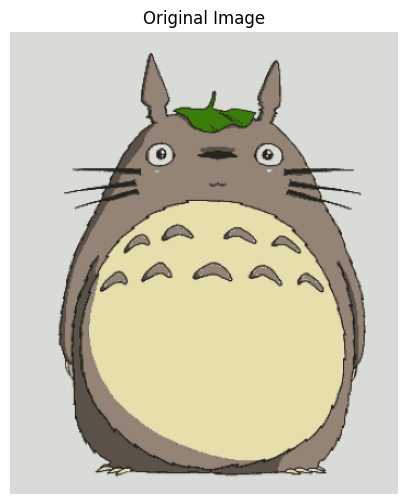

In [44]:
# -----------------------------------------------------------------------------
# Step 2: Check alpha & prepare image for processing
# -----------------------------------------------------------------------------
has_alpha = (img.mode in ('RGBA', 'LA'))

if has_alpha:
    img_np = np.array(img)
    rgb_img = img_np[..., :3]           # extract RGB channels
    alpha_channel = img_np[..., 3]        # extract alpha channel
    fg_mask = alpha_channel > 0           # foreground mask from alpha

    # Get image dimensions
    height, width = rgb_img.shape[:2]

    # Adaptive tile size: 2% of the smaller dimension (ensuring at least 1 pixel)
    tile_size = max(1, int(min(height, width) * 0.02))

    # Define colors for checkered pattern
    color1 = np.array([255, 255, 255], dtype=np.uint8)  # white tile
    color2 = np.array([200, 200, 200], dtype=np.uint8)  # light gray tile

    # Create a checkered background using a vectorized approach:
    y, x = np.indices((height, width))
    checkerboard = ((x // tile_size + y // tile_size) % 2 == 0)
    background = np.where(checkerboard[..., None], color1, color2)

    # Composite the image: use rgb_img where alpha is present, else use checkered background
    display_img = np.where(fg_mask[..., None], rgb_img, background)
else:
    img_np = np.array(img.convert('RGB'))  # ensure RGB format
    rgb_img = img_np
    fg_mask = np.ones(rgb_img.shape[:2], dtype=bool)  # all pixels are foreground
    display_img = rgb_img  # no modification needed

# Show the loaded image
height, width = rgb_img.shape[:2]
display_image(display_img, title="Original Image")

# Note: rgb_img is still the one we want to work


## Obtaining the main colors in the image



### Meanshift in Lab space

After some experimentation I decided to use the mean shift algorithm in the Lab colorspace of the image to cluster the main colors in the image. We first scale down the image and only use a subset of those pixels to calculate the bandwith used in meanshift, changing these values might produce better results but it will take longer and MS is already initialization dependent.

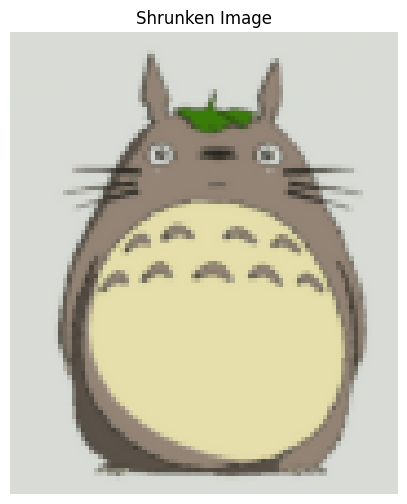

Estimating bandwidth for MeanShift on the shrunken image...
Estimated bandwidth = 2.81
Running MeanShift on the shrunken image...
MeanShift found 52 clusters.


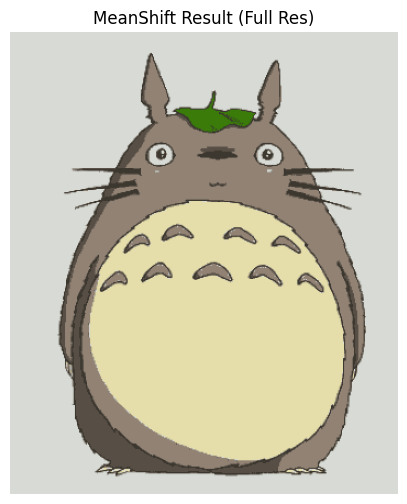

MeanShift palette has 39 colors.


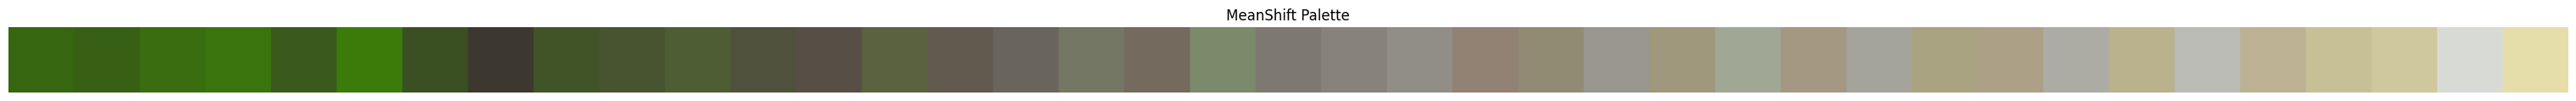

In [45]:
# -----------------------------------------------------------------------------
# Step 3: Downscale, Convert to Lab, and MeanShift Clustering
# -----------------------------------------------------------------------------
scale_factor = 0.25 # keep small if big image
newH, newW = int(height * scale_factor), int(width * scale_factor)
shrunken_img = resize(rgb_img, (newH, newW), anti_aliasing=True, preserve_range=True).astype(np.uint8)
display_image(shrunken_img, title="Shrunken Image")

# Convert to Lab and prepare for clustering
lab_small = rgb2lab(shrunken_img)
pixels_lab_small = lab_small.reshape((-1, 3))

# Sample small portion for bandwidth estimation
sample_size = int(0.25 * pixels_lab_small.shape[0])
sample_indices = np.random.choice(pixels_lab_small.shape[0], sample_size, replace=False)
sample_data_small = pixels_lab_small[sample_indices]

print("Estimating bandwidth for MeanShift on the shrunken image...")
bandwidth = estimate_bandwidth(sample_data_small, quantile=0.1, n_samples=sample_size)
print(f"Estimated bandwidth = {bandwidth:.2f}")

# Run MeanShift
print("Running MeanShift on the shrunken image...")
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(pixels_lab_small)
labels_small = ms.labels_
cluster_centers_ms = ms.cluster_centers_
print(f"MeanShift found {len(np.unique(labels_small))} clusters.")

# Apply clusters to full-resolution image
lab_full = rgb2lab(rgb_img)
pixels_lab_full = lab_full.reshape((-1, 3))
dists = distance.cdist(pixels_lab_full, cluster_centers_ms)
closest_centers = np.argmin(dists, axis=1)
new_lab_img = cluster_centers_ms[closest_centers].reshape(lab_full.shape)
new_rgb_img = lab2rgb(new_lab_img)
new_rgb_img_255 = (np.clip(new_rgb_img, 0, 1) * 255).astype(np.uint8)

# Merge alpha if present
if has_alpha:
    mean_shift_img = np.dstack((new_rgb_img_255, alpha_channel))
    display_ms = new_rgb_img_255.copy()
    display_ms = np.where(fg_mask[..., None], display_ms, background)
else:
    mean_shift_img = new_rgb_img_255
    display_ms = mean_shift_img

display_image(display_ms, title="MeanShift Result (Full Res)")

# Extract palette from result
ms_unique_colors = get_unique_colors(new_rgb_img_255[fg_mask].reshape(-1, 3))
ms_palette = [tuple(c) for c in ms_unique_colors]
print(f"MeanShift palette has {len(ms_palette)} colors.")
display_palette(ms_palette, title="MeanShift Palette")


## K-means

Now we will also use K-means to calculate the most common colors in the image, the advtange of this is we can define the number of clusters however kmeans can kind of be considered as global mean shift so images with a taint or a heavy bakground color will kind of overpower the color intensity of less prevalent colors

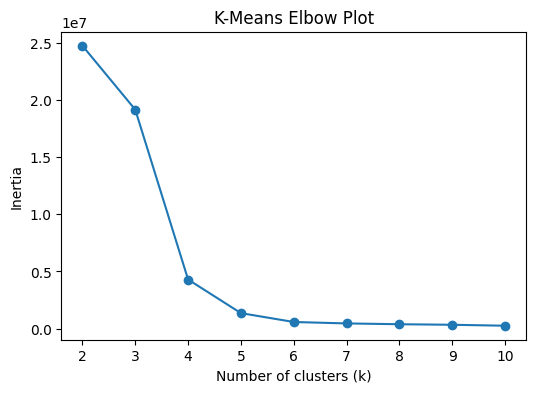

In [46]:
# -----------------------------------------------------------------------------
# Elbow Method: Determine a good 'k' by plotting inertia vs. k
# -----------------------------------------------------------------------------
k_values = range(2, 11)
inertias = []
pixels_lab = rgb2lab(display_img.astype(np.float64)/255.0).reshape((-1, 3))

for k in k_values:
    kmeans_temp = KMeans(n_clusters=k, random_state=42)
    kmeans_temp.fit(pixels_lab)
    inertias.append(kmeans_temp.inertia_)

plt.figure(figsize=(6,4))
plt.plot(k_values, inertias, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("K-Means Elbow Plot")
plt.show()

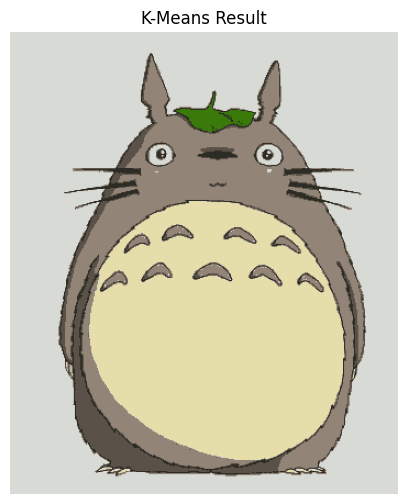

K-Means palette has 6 colors.


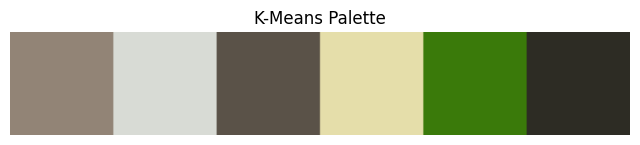

In [47]:
# -----------------------------------------------------------------------------
# Choose the number of clusters (e.g. after examining the elbow plot)
# -----------------------------------------------------------------------------
k = 6 # Change this as desired
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(pixels_lab)
labels_km = kmeans.labels_
cluster_centers_km = kmeans.cluster_centers_
cluster_centers_rgb = lab2rgb(cluster_centers_km.reshape(1, -1, 3)).reshape(-1, 3)

new_lab_img = cluster_centers_km[labels_km].reshape(lab_full.shape)
new_rgb_img = lab2rgb(new_lab_img)
new_rgb_img_255 = (np.clip(new_rgb_img, 0, 1) * 255).astype(np.uint8)

if has_alpha:
    kmeans_img = np.dstack((new_rgb_img_255, alpha_channel))
    display_km = new_rgb_img_255.copy()
    display_km = np.where(fg_mask[..., None], display_km, background)
else:
    kmeans_img = new_rgb_img_255
    display_km = kmeans_img

display_image(display_km, title="K-Means Result")
km_palette = (cluster_centers_rgb * 255).astype(np.uint8).tolist()
print(f"K-Means palette has {len(km_palette)} colors.")
display_palette(km_palette, title="K-Means Palette")


In [48]:
def optimized_recolor_image_to_palette(rgb_img, palette):
    """
    Reassign each pixel in 'rgb_img' to the closest color in 'palette' using a vectorized
    approach in Lab space.
    """
    H, W = rgb_img.shape[:2]
    lab_pixels = rgb2lab(rgb_img.astype(np.float64)/255.0).reshape(-1, 3)
    palette_arr = np.array(palette, dtype=np.uint8)
    palette_lab = rgb2lab(palette_arr[np.newaxis, ...].astype(np.float64)/255.0).reshape(-1, 3)
    nearest_indices = np.argmin(distance.cdist(lab_pixels, palette_lab), axis=1)
    return palette_arr[nearest_indices].reshape(H, W, 3)


How many final colors do you want? 0
Merging the MeanShift palette from 39 to 0 colors...
(Skipped recoloring for speed.) Using 6 colors after reduction.



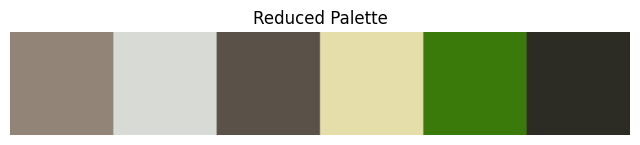

In [51]:
# -----------------------------------------------------------------------------
# Step 4: Reduce MeanShift Palette to User-defined Number of Colors
# -----------------------------------------------------------------------------
user_n = int(input("How many final colors do you want? "))
print(f"Merging the MeanShift palette from {len(ms_palette)} to {user_n} colors...")

# Reduce using hierarchical clustering in Lab space
if user_n <= 0:
  final_palette = km_palette
else:
  final_palette = reduce_palette_to_n_colors(ms_palette, user_n)
  print(f"Palette is now {len(final_palette)} colors.")

# Optional: Skip slow pixel-wise recoloring and just use reduced palette for next stage
# If you want to preview the recolored image, uncomment below:
# final_array = optimized_recolor_image_to_palette(mean_shift_img[..., :3] if has_alpha else mean_shift_img, final_palette)
# if has_alpha:
#     final_img_np = np.dstack((final_array, alpha_channel))
#     display_new = final_array.copy()
#     display_new[~fg_mask] = [255, 255, 255]
# else:
#     final_img_np = final_array
#     display_new = final_img_np
# display_image(display_new, title=f"Recolor with {user_n} Colors")

# Instead, just show the reduced palette
palette_after_reduce_tuples = final_palette
print(f"(Skipped recoloring for speed.) Using {len(palette_after_reduce_tuples)} colors after reduction.\n")
display_palette(palette_after_reduce_tuples, title="Reduced Palette")


Combined palette length (before re-clustering) = 6
Final palette length (after re-clustering to 6) = 6


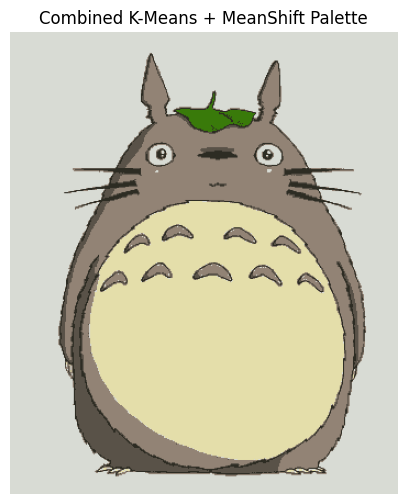

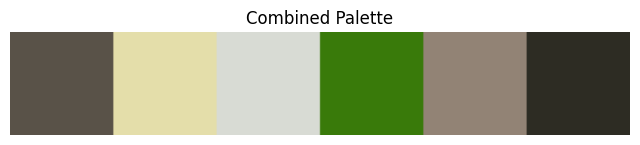

In [52]:
# -----------------------------------------------------------------------------
# Merge palettes and re-cluster using Lab distances
# -----------------------------------------------------------------------------
combined_palette = merge_palettes_remove_duplicates(km_palette, palette_after_reduce_tuples, threshold=5.0)
print(f"Combined palette length (before re-clustering) = {len(combined_palette)}")

desired_k = 6  # Change as desired
final_palette = recluster_palette(combined_palette, final_k=desired_k)
print(f"Final palette length (after re-clustering to {desired_k}) = {len(final_palette)}")

# Recolor original image with final combined palette
final_quantized_img = optimized_recolor_image_to_palette(rgb_img, final_palette)

if has_alpha:
    final_img = np.dstack((final_quantized_img, alpha_channel))
    display_final = final_quantized_img.copy()
    display_final = np.where(fg_mask[..., None], display_final, background)
else:
    final_img = final_quantized_img
    display_final = final_quantized_img

display_image(display_final, title="Combined K-Means + MeanShift Palette")
display_palette(final_palette, title="Combined Palette")


Found 6 unique colors in the image.


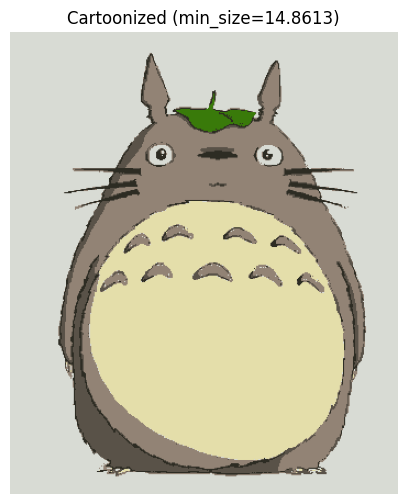

True

In [56]:
def remove_small_splotches_colorwise(img, min_size=1):
    """
    Removes small isolated color patches in an image by reassigning them to the most
    frequent neighboring color. Operates per unique color label.
    Optimized version uses find_objects and binary_dilation to reduce per-pixel loops.
    """

    cleaned = img.copy()
    # Find unique colors by flattening the color channels
    unique_colors = np.unique(cleaned.reshape(-1, cleaned.shape[-1]), axis=0)

    print(f"Found {len(unique_colors)} unique colors in the image.")

    for color in unique_colors:
        # Create mask for the current color
        mask = np.all(cleaned == color, axis=-1)
        # Label connected regions in the mask
        labeled_mask, num_labels = label(mask, structure=np.ones((3, 3)))
        # Get slices for each connected component
        slices = find_objects(labeled_mask)
        if slices is None:
            continue

        for label_id, slc in enumerate(slices, start=1):
            # Extract the region for the current label within its bounding box
            region = (labeled_mask[slc] == label_id)
            region_size = np.sum(region)
            if region_size < min_size:
                # Compute the dilated region and subtract the original region to get neighbors
                dilated = binary_dilation(region, structure=np.ones((3, 3)))
                neighbor_mask = dilated & (~region)
                # Get neighbor coordinates relative to the slice, then convert to image coordinates
                neighbor_coords = np.argwhere(neighbor_mask)
                if neighbor_coords.size == 0:
                    continue
                # Adjust coordinates to full image indices
                neighbor_coords[:, 0] += slc[0].start
                neighbor_coords[:, 1] += slc[1].start
                # Gather neighbor colors
                neighbor_colors = [tuple(cleaned[r, c]) for r, c in neighbor_coords]
                if neighbor_colors:
                    most_common_color = Counter(neighbor_colors).most_common(1)[0][0]
                    # Update all pixels in the connected region at once
                    region_coords = np.argwhere(labeled_mask[slc] == label_id)
                    for r_offset, c_offset in region_coords:
                        cleaned[r_offset + slc[0].start, c_offset + slc[1].start] = most_common_color
    return cleaned

# Determine a size threshold for removing splotches
percent_size = 1  # percent of total image area
min_size_threshold = percent_size * (width * height) / (100 * 100)

# Apply cartoon-style cleanup
cartoonized_img = remove_small_splotches_colorwise(final_quantized_img, min_size=min_size_threshold)
if has_alpha:
    final_img = np.dstack((cartoonized_img, alpha_channel))
    display_final = cartoonized_img.copy()
    display_final = np.where(fg_mask[..., None], display_final, background)
else:
    final_img = cartoonized_img
    display_final = cartoonized_img

display_image(display_final, title=f"Cartoonized (min_size={min_size_threshold})")

cv2.imwrite('img.png', display_final)

# Edge detection

In [71]:

# ==============================================================================
# Imports
# ==============================================================================
from typing import Tuple, List, Optional, Dict, Any
import io
import base64
import time
import os

# ipywidgets imports
import ipywidgets as widgets
from ipywidgets import (
    interactive_output, HBox, VBox, Layout, FloatLogSlider, Dropdown, Button, Tab, Text
)
from IPython.display import display, clear_output


In [72]:
# ==============================================================================
# Type Aliases
# ==============================================================================
ImageGray = np.ndarray
ImageBGR = np.ndarray
ImageBGRA = np.ndarray
Contour = np.ndarray  # Usually (N, 1, 2) dtype=int32

# ==============================================================================
# Functions: Loading, Filtering, and Visualization
# ==============================================================================

def load_image_from_upload(upload_widget_value):
    if not upload_widget_value:
        return None, None, None
    uploaded_filename = list(upload_widget_value.keys())[0]
    file_info = upload_widget_value[uploaded_filename]
    content = file_info['content']
    nparr = np.frombuffer(content, np.uint8)
    img = cv2.imdecode(nparr, cv2.IMREAD_UNCHANGED)
    if img is None:
        print(f"Error decoding '{uploaded_filename}'")
        return None, None, None
    print(f"Loaded '{uploaded_filename}': {img.shape}, {img.dtype}")
    base_name = os.path.splitext(uploaded_filename)[0]
    return img, uploaded_filename, base_name

def load_image_from_file(filename):
    img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
    if img is None:
        print(f"Error reading '{filename}'")
        return None, None
    print(f"Loaded '{filename}': {img.shape}, {img.dtype}")
    base_name = os.path.splitext(os.path.basename(filename))[0]
    return img, base_name

def filter_contours(contours: List[Contour], hierarchy: Optional[np.ndarray],
                    min_pixel_area: float, max_pixel_area: float,
                    min_pixel_perimeter: float, contour_mode_enum: int) -> List[Contour]:
    if not contours:
        return []
    filtered = []
    for i, cnt in enumerate(contours):
        area = cv2.contourArea(cnt)
        if not (min_pixel_area <= area <= max_pixel_area):
            continue
        if min_pixel_perimeter > 0:
            perimeter = cv2.arcLength(cnt, True)
            if perimeter < min_pixel_perimeter:
                continue
        filtered.append(cnt)
    return filtered

def list_image_files(directory="."):
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']
    return [f for f in os.listdir(directory) if os.path.splitext(f)[1].lower() in image_extensions]

def visualize_results(
    original_image: np.ndarray,   # Can be BGR or BGRA
    edge_map: ImageGray,
    all_contours: List[Contour],
    filtered_contours: List[Contour]
    ) -> None:
    """Displays the original image, edge map, all contours, and filtered contours."""

    # Prepare a BGR version for drawing contours
    if len(original_image.shape) == 2:  # Grayscale
        display_bgr = cv2.cvtColor(original_image, cv2.COLOR_GRAY2BGR)
    elif original_image.shape[2] == 4:  # BGRA
        display_bgr = original_image[:, :, :3].copy()
    else:  # BGR
        display_bgr = original_image.copy()

    # Create white canvases
    all_contours_canvas = np.full_like(display_bgr, 255)
    filtered_contours_canvas = np.full_like(display_bgr, 255)

    # Draw contours (black lines)
    cv2.drawContours(all_contours_canvas, all_contours, -1, (0, 0, 0), 1)
    cv2.drawContours(filtered_contours_canvas, filtered_contours, -1, (0, 0, 0), 1)

    # Plot using a 2x2 grid
    plt.figure(figsize=(10, 8))

    # 1. Original Image
    plt.subplot(2, 2, 1)
    if len(original_image.shape) == 2:
         plt.imshow(original_image, cmap='gray')
         plt.title("Original Grayscale Image")
    elif original_image.shape[2] == 4:
         plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGRA2RGB))
         plt.title("Original Image (BGRA)")
    else:
         plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
         plt.title("Original Image (BGR)")
    plt.axis('off')

    # 2. Edge Map
    plt.subplot(2, 2, 2)
    plt.imshow(edge_map, cmap='gray')
    plt.title("Detected Edges (Canny + Morph Close)")
    plt.axis('off')

    # 3. All Contours
    plt.subplot(2, 2, 3)
    plt.imshow(cv2.cvtColor(all_contours_canvas, cv2.COLOR_BGR2RGB))
    plt.title(f"All Contours Found ({len(all_contours)})")
    plt.axis('off')

    # 4. Filtered Contours
    plt.subplot(2, 2, 4)
    plt.imshow(cv2.cvtColor(filtered_contours_canvas, cv2.COLOR_BGR2RGB))
    plt.title(f"Filtered Contours ({len(filtered_contours)})")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


In [73]:
# ==============================================================================
# Define Widgets
# ==============================================================================

# --- Edge Detection Widgets ---
w_blur_ksize = widgets.IntSlider(value=3, min=0, max=15, step=1,
                                   description='Blur Kernel:',
                                   continuous_update=False)
w_canny_thresh1 = widgets.IntSlider(value=50, min=0, max=300, step=5,
                                      description='Canny Thresh1:',
                                      continuous_update=False)
w_canny_thresh2 = widgets.IntSlider(value=150, min=0, max=500, step=5,
                                      description='Canny Thresh2:',
                                      continuous_update=False)
w_use_morph_close = widgets.Checkbox(value=True, description='Use Morph Close')
w_morph_ksize = widgets.IntSlider(value=3, min=0, max=15, step=1,
                                  description='Morph Kernel:',
                                  continuous_update=False)

# --- Contour Mode Widget ---
contour_mode_options = {
    'External': cv2.RETR_EXTERNAL,
    'List': cv2.RETR_LIST,
    'Tree': cv2.RETR_TREE,
    'CComp': cv2.RETR_CCOMP
}
w_contour_mode = widgets.Dropdown(
    options=contour_mode_options,
    value=cv2.RETR_EXTERNAL,
    description='Contour Mode:',
    style={'description_width': 'initial'}
)

# --- Contour Filtering Parameter Widgets on Log Scale ---
w_min_area_percent = FloatLogSlider(
    value=0.01, base=10, min=-4, max=2, step=0.05,
    description='Min Area (%):',
    readout_format='.4f',
    continuous_update=False,
    style={'description_width': 'initial'}
)
w_max_area_percent = FloatLogSlider(
    value=95.0, base=10, min=-1, max=2, step=0.05,
    description='Max Area (%):',
    readout_format='.1f',
    continuous_update=False,
    style={'description_width': 'initial'}
)
w_min_perimeter_percent = FloatLogSlider(
    value=0.5, base=10, min=-2, max=2, step=0.05,
    description='Min Perimeter (%):',
    readout_format='.3f',
    continuous_update=False,
    style={'description_width': 'initial'}
)
w_include_border = widgets.Checkbox(
    value=False,
    description="Include Image Border as Contour"
)

# --- File Selection Widgets ---
file_selector = Dropdown(
    options=list_image_files(),
    description='Select file:',
    disabled=False,
)
refresh_button = Button(description="Refresh Files")
load_file_button = Button(description="Load File")

def refresh_file_list(b):
    files = list_image_files()
    file_selector.options = files if files else ["No image files found"]
    print("File list refreshed.")

refresh_button.on_click(refresh_file_list)

In [74]:
# ==============================================================================
# Edge Extraction Function
# ==============================================================================

def extract_edges_canny(
    image_gray: ImageGray,
    blur_ksize: int = 5,
    canny_threshold1: int = 50,
    canny_threshold2: int = 150,
    use_morph_close: bool = True,
    morph_ksize: int = 3
    ) -> ImageGray:
    """
    Extracts edges using the Canny algorithm with optional morphological closing.
    """
    # Optional Gaussian Blur
    if blur_ksize > 1 and blur_ksize % 2 == 1:
        blurred_img = cv2.GaussianBlur(image_gray, (blur_ksize, blur_ksize), 0)
        print(f"Applied Gaussian Blur with ksize={blur_ksize}")
    else:
        blurred_img = image_gray
        print("Skipped Gaussian Blur.")

    # Canny Edge Detection
    edges = cv2.Canny(blurred_img, canny_threshold1, canny_threshold2)
    print(f"Applied Canny Edge Detection with thresholds=({canny_threshold1}, {canny_threshold2})")

    # Optional Morphological Closing
    if use_morph_close and morph_ksize > 0:
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (morph_ksize, morph_ksize))
        edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
        print(f"Applied Morphological Closing with ksize={morph_ksize}")
    else:
        print("Skipped Morphological Closing.")

    return edges


In [75]:
# ==============================================================================
# Global Variables and Uploader Widget
# ==============================================================================

loaded_image_data = {
    "original": None,
    "grayscale": None,
    "filename_base": None,  # For output filenames
    "height": 0,
    "width": 0,
    "total_area": 0,
    "perimeter_ref": 0,
    "latest_filtered_contours": None  # To store filtered contours
}

uploader = widgets.FileUpload(
    accept='image/*',  # Accept image file types
    multiple=False,    # Allow only single file upload
    description='Upload Image'
)

In [76]:
# ==============================================================================
# File Upload/Selection Callbacks
# ==============================================================================

def on_load_file(b):
    filename = file_selector.value
    if not filename or filename == "No image files found":
        print("No valid file selected.")
        return

    with out:
        clear_output(wait=True)
        print(f"Attempting to load file: {filename}")
        img_original, filename_base = load_image_from_file(filename)

        if img_original is not None:
            loaded_image_data["original"] = img_original
            loaded_image_data["filename_base"] = filename_base
            loaded_image_data["latest_filtered_contours"] = None

            # Grayscale conversion
            if len(img_original.shape) == 2:
                img_gray = img_original
            elif img_original.shape[2] == 3:
                img_gray = cv2.cvtColor(img_original, cv2.COLOR_BGR2GRAY)
            elif img_original.shape[2] == 4:
                img_gray = cv2.cvtColor(img_original, cv2.COLOR_BGRA2GRAY)
            else:
                print(f"Error: Shape {img_original.shape}")
                loaded_image_data["original"] = None
                return
            if img_gray.dtype != np.uint8:
                if np.max(img_gray) <= 1.0 + 1e-6 and np.min(img_gray) >= 0.0 - 1e-6:
                    img_gray = (img_gray * 255).astype(np.uint8)
                else:
                    img_gray = np.clip(img_gray, 0, 255).astype(np.uint8)

            loaded_image_data["grayscale"] = img_gray
            h, w = img_gray.shape[:2]
            loaded_image_data["height"] = h
            loaded_image_data["width"] = w
            loaded_image_data["total_area"] = float(h * w)
            loaded_image_data["perimeter_ref"] = float(h + w)
            print(f"Image dims: {w}x{h}, Area: {loaded_image_data['total_area']:.0f}")
            print("Running initial processing...")
            interactive_process_image(
                w_blur_ksize.value, w_canny_thresh1.value, w_canny_thresh2.value,
                w_use_morph_close.value, w_morph_ksize.value, w_contour_mode.value,
                w_min_area_percent.value, w_max_area_percent.value, w_min_perimeter_percent.value
            )
        else:
            loaded_image_data["original"] = None
            loaded_image_data["grayscale"] = None
            loaded_image_data["filename_base"] = None
            loaded_image_data["latest_filtered_contours"] = None
            print("Image loading failed.")

load_file_button.on_click(on_load_file)

file_select_box = VBox([HBox([file_selector, refresh_button, load_file_button])])
refresh_file_list(None)  # Initialize file list


File list refreshed.


In [77]:
# ==============================================================================
# Interactive Processing Function
# ==============================================================================

def interactive_process_image(
    blur_ksize, canny_thresh1, canny_thresh2, use_morph_close, morph_ksize,
    contour_mode_enum, min_area_p, max_area_p, min_perimeter_p
    ):
    with save_status:
        clear_output()

    img_original = loaded_image_data["original"]
    img_gray = loaded_image_data["grayscale"]
    total_area = loaded_image_data["total_area"]
    perimeter_ref = loaded_image_data["perimeter_ref"]

    if img_original is None or img_gray is None:
        print("Waiting for image upload/selection...")
        loaded_image_data["latest_filtered_contours"] = None
        return

    print("Processing with new parameters...")
    edge_map = extract_edges_canny(img_gray, blur_ksize, canny_thresh1, canny_thresh2,
                                   use_morph_close, morph_ksize)
    all_contours, hierarchy = cv2.findContours(
        edge_map.copy(), contour_mode_enum, cv2.CHAIN_APPROX_SIMPLE
    )
    all_contours = list(all_contours)
    print(f"Found {len(all_contours)} initial contours.")

    min_pixel_area = (min_area_p / 100.0) * total_area
    max_pixel_area = (max_area_p / 100.0) * total_area
    min_pixel_perimeter = (min_perimeter_p / 100.0) * perimeter_ref
    print(f"Filtering (Pixels): MinArea={min_pixel_area:.1f}, MaxArea={max_pixel_area:.1f}, MinPerim={min_pixel_perimeter:.1f}")

    current_hierarchy = hierarchy if contour_mode_enum in [cv2.RETR_TREE, cv2.RETR_CCOMP] else None
    filtered_contours = filter_contours(all_contours, current_hierarchy,
                                        min_pixel_area, max_pixel_area,
                                        min_pixel_perimeter, contour_mode_enum)

    if w_include_border.value:
        h, w = loaded_image_data["height"], loaded_image_data["width"]
        border_contour = np.array([[[0, 0]], [[w - 1, 0]], [[w - 1, h - 1]], [[0, h - 1]]], dtype=np.int32)
        print("Including image border as a contour.")
        # Append the border contour to both lists
        all_contours.append(border_contour)
        filtered_contours.append(border_contour)

    print(f"Kept {len(filtered_contours)} contours.")

    loaded_image_data["latest_filtered_contours"] = filtered_contours
    visualize_results(img_original, edge_map, all_contours, filtered_contours)

In [78]:
# ==============================================================================
# Save Filtered Contours Functions & Callbacks
# ==============================================================================

save_button = Button(description="Save Filtered Contours", button_style='success', icon='save')
save_status = widgets.Output()

def save_filtered_contours(contours_to_save: List[Contour], height: int, width: int, base_filename: str):
    if contours_to_save is None:
        with save_status:
            clear_output(wait=True)
            print("No filtered contours available to save.")
        return
    if not base_filename:
        base_filename = "output"
        print("Warning: Original filename not found, using default 'output'.")

    img_filename = f"{base_filename}_filtered_contours.png"
    data_filename = f"{base_filename}_filtered_contours.npz"

    with save_status:
        clear_output(wait=True)
        print(f"Saving {len(contours_to_save)} contours...")

        try:
            canvas = np.full((height, width, 3), 255, dtype=np.uint8)
            cv2.drawContours(canvas, contours_to_save, -1, (0, 0, 0), 1)
            cv2.imwrite(img_filename, canvas)
            print(f"✔️ Saved contour image to: {img_filename}")
        except Exception as e:
            print(f"❌ Error saving contour image: {e}")

        try:
            contour_dict = {f"contour_{i}": cnt for i, cnt in enumerate(contours_to_save)}
            if contour_dict:
                 np.savez_compressed(data_filename, **contour_dict)
                 print(f"✔️ Saved contour data to: {data_filename}")
            elif not contours_to_save:
                 print("ℹ️ No contours remained after filtering, .npz file not saved.")
            else:
                 print("ℹ️ No contour data to save in .npz file.")
        except Exception as e:
            print(f"❌ Error saving contour data: {e}")

def on_save_button_clicked(b):
    contours = loaded_image_data.get("latest_filtered_contours")
    h = loaded_image_data.get("height")
    w = loaded_image_data.get("width")
    fname_base = loaded_image_data.get("filename_base")

    if h is None or w is None or h == 0 or w == 0:
         with save_status:
             clear_output(wait=True)
             print("Cannot save: Image dimensions not found.")
         return
    if fname_base is None:
         with save_status:
             clear_output(wait=True)
             print("Cannot save: Base filename not found.")
         return

    save_filtered_contours(contours, h, w, fname_base)

save_button.on_click(on_save_button_clicked)


In [79]:
# ==============================================================================
# Connect Widgets to the Processing Function
# ==============================================================================

controls = HBox([
    VBox([w_blur_ksize, w_canny_thresh1, w_canny_thresh2,
          HBox([w_use_morph_close, w_morph_ksize]), w_include_border]),
    VBox([w_contour_mode, w_min_area_percent, w_max_area_percent, w_min_perimeter_percent])
])
out = widgets.interactive_output(
    interactive_process_image,
    {
        'blur_ksize': w_blur_ksize,
        'canny_thresh1': w_canny_thresh1,
        'canny_thresh2': w_canny_thresh2,
        'use_morph_close': w_use_morph_close,
        'morph_ksize': w_morph_ksize,
        'contour_mode_enum': w_contour_mode,
        'min_area_p': w_min_area_percent,
        'max_area_p': w_max_area_percent,
        'min_perimeter_p': w_min_perimeter_percent
    }
)

# --- Create Tabs for Upload/Selection ---
upload_tab = VBox([uploader])
select_tab = file_select_box
tab = Tab(children=[upload_tab, select_tab])
tab.set_title(0, "Upload from Computer")
tab.set_title(1, "Select from Colab")

In [80]:
# ==============================================================================
# Observer for File Upload
# ==============================================================================

def on_upload_change(change):
    with out:
        clear_output(wait=True)
        if change['new']:
            uploaded_value = change['owner'].value
            img_original, filename, filename_base = load_image_from_upload(uploaded_value)
            if img_original is not None:
                loaded_image_data["original"] = img_original
                loaded_image_data["filename_base"] = filename_base
                loaded_image_data["latest_filtered_contours"] = None

                if len(img_original.shape) == 2:
                    img_gray = img_original
                elif img_original.shape[2] == 3:
                    img_gray = cv2.cvtColor(img_original, cv2.COLOR_BGR2GRAY)
                elif img_original.shape[2] == 4:
                    img_gray = cv2.cvtColor(img_original, cv2.COLOR_BGRA2GRAY)
                else:
                    print(f"Error: Shape {img_original.shape}")
                    loaded_image_data["original"] = None
                    return
                if img_gray.dtype != np.uint8:
                     if np.max(img_gray) <= 1.0 + 1e-6 and np.min(img_gray) >= 0.0 - 1e-6:
                         img_gray = (img_gray * 255).astype(np.uint8)
                     else:
                         img_gray = np.clip(img_gray, 0, 255).astype(np.uint8)

                loaded_image_data["grayscale"] = img_gray
                h, w = img_gray.shape[:2]
                loaded_image_data["height"] = h
                loaded_image_data["width"] = w
                loaded_image_data["total_area"] = float(h * w)
                loaded_image_data["perimeter_ref"] = float(h + w)
                print(f"Image dims: {w}x{h}, Area: {loaded_image_data['total_area']:.0f}")
                print("Running initial processing...")
                interactive_process_image(
                    w_blur_ksize.value, w_canny_thresh1.value, w_canny_thresh2.value,
                    w_use_morph_close.value, w_morph_ksize.value, w_contour_mode.value,
                    w_min_area_percent.value, w_max_area_percent.value, w_min_perimeter_percent.value
                )
            else:
                loaded_image_data["original"] = None
                loaded_image_data["grayscale"] = None
                loaded_image_data["filename_base"] = None
                loaded_image_data["latest_filtered_contours"] = None
                print("Image loading failed.")
        else:
            loaded_image_data["original"] = None
            loaded_image_data["grayscale"] = None
            loaded_image_data["filename_base"] = None
            loaded_image_data["latest_filtered_contours"] = None
            print("Upload cleared.")

In [81]:
# ==============================================================================
# Display Everything
# ==============================================================================

display(tab)
display(controls)
display(out)
display(save_button)
display(save_status)

uploader.observe(on_upload_change, names='value')


Output()

Button(button_style='success', description='Save Filtered Contours', icon='save', style=ButtonStyle())

Output()

# Tiling approach

In [82]:
final_palette

[(89, 82, 72),
 (228, 222, 170),
 (216, 219, 212),
 (57, 122, 10),
 (146, 131, 117),
 (45, 44, 35)]

Available keys in NPZ file: ['contour_0', 'contour_1', 'contour_2', 'contour_3', 'contour_4', 'contour_5', 'contour_6', 'contour_7', 'contour_8', 'contour_9', 'contour_10', 'contour_11', 'contour_12', 'contour_13', 'contour_14', 'contour_15', 'contour_16', 'contour_17', 'contour_18', 'contour_19', 'contour_20', 'contour_21', 'contour_22', 'contour_23', 'contour_24', 'contour_25', 'contour_26', 'contour_27', 'contour_28', 'contour_29', 'contour_30', 'contour_31', 'contour_32', 'contour_33', 'contour_34', 'contour_35', 'contour_36', 'contour_37', 'contour_38', 'contour_39', 'contour_40', 'contour_41', 'contour_42', 'contour_43']
Successfully loaded 44 contours from keys 'contour_0' to 'contour_43' in 'img_filtered_contours.npz'.
Image dimensions loaded from 'img_filtered_contours.png': 353x421

--- Visualizing Individual Contours ---


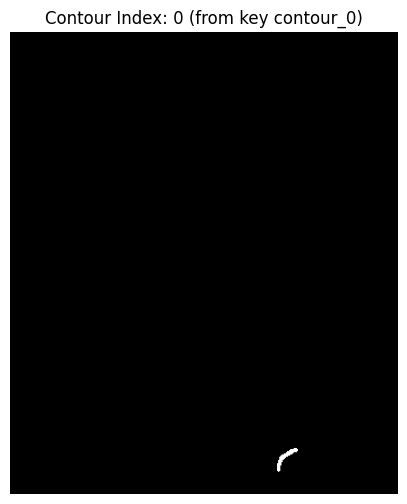

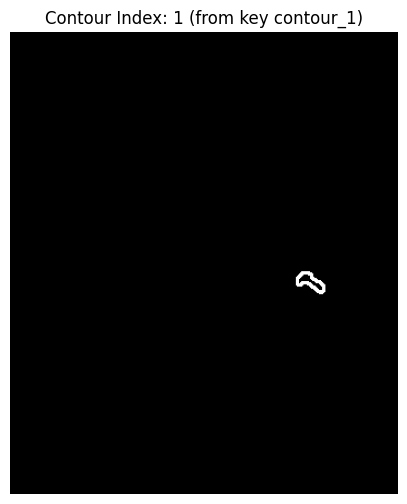

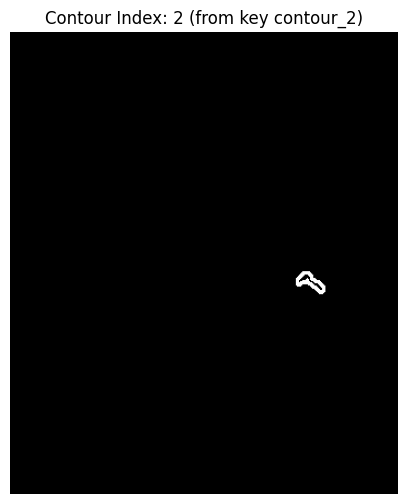

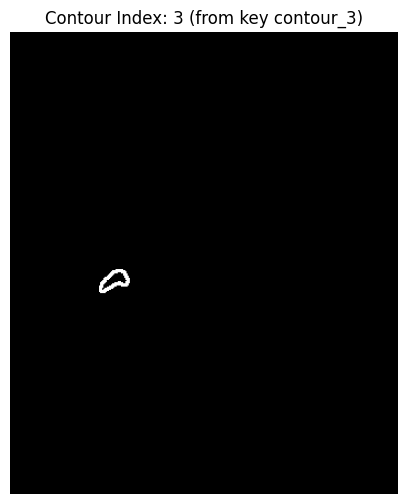

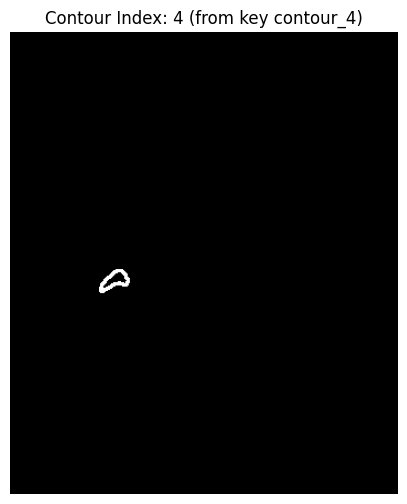

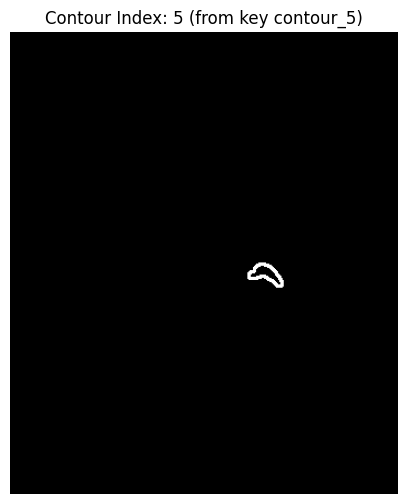

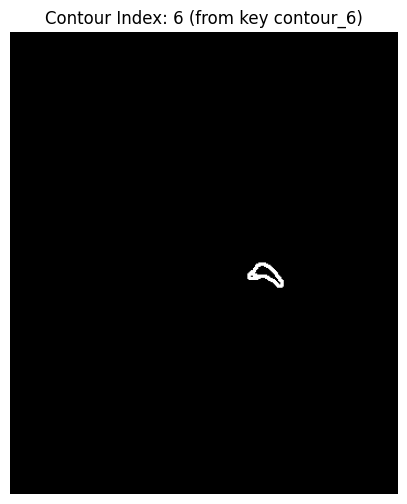

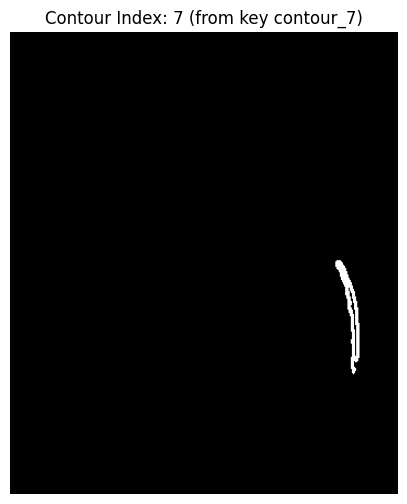

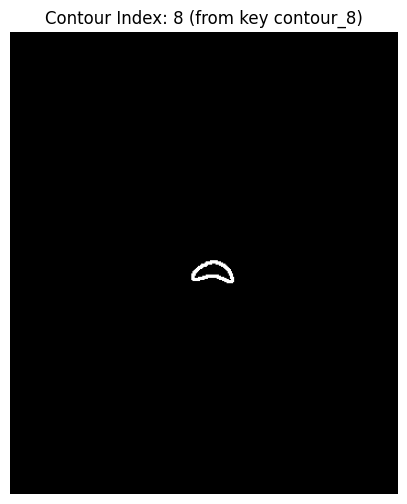

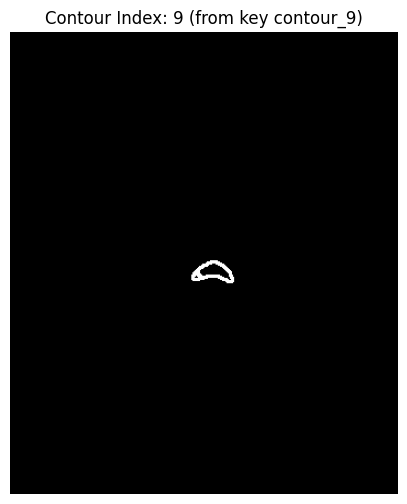

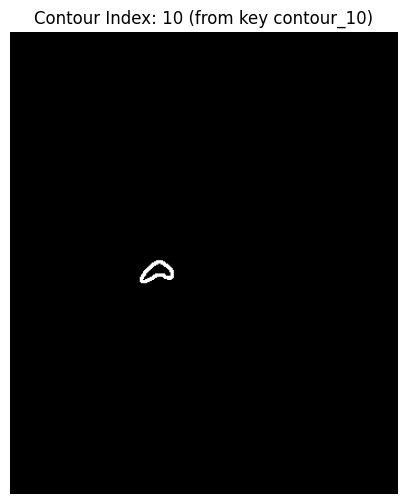

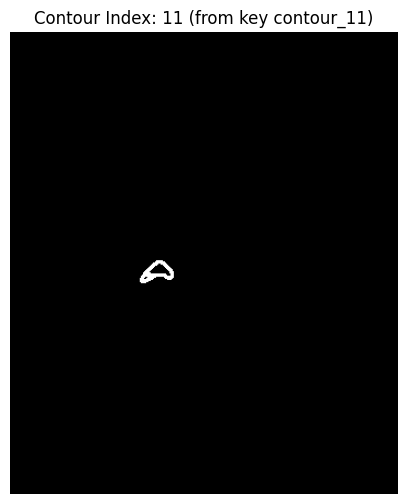

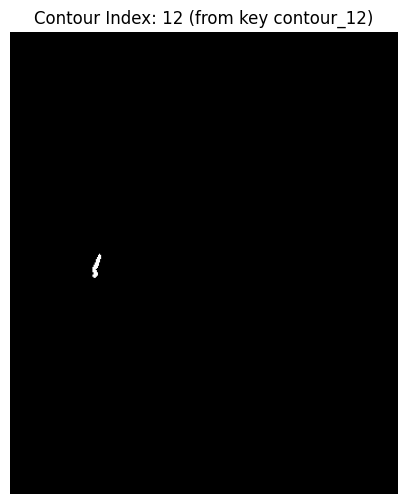

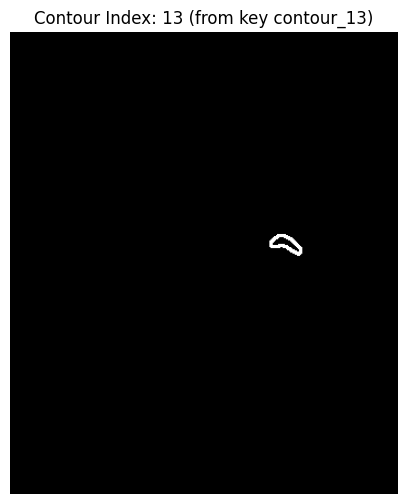

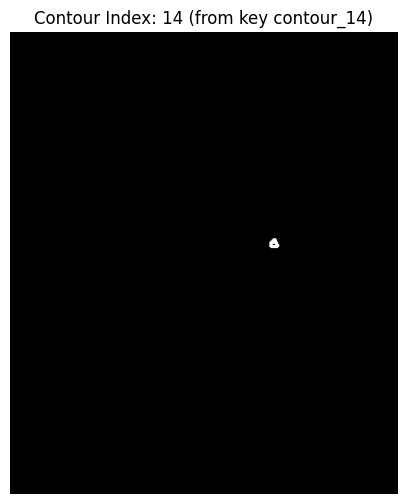

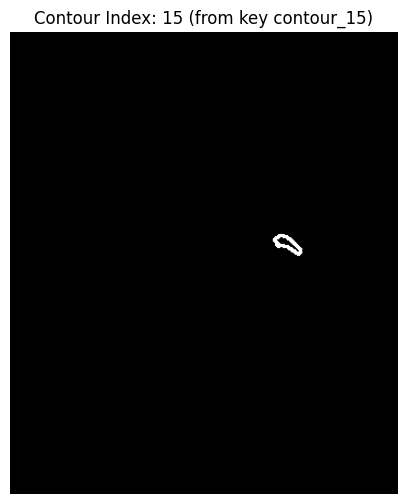

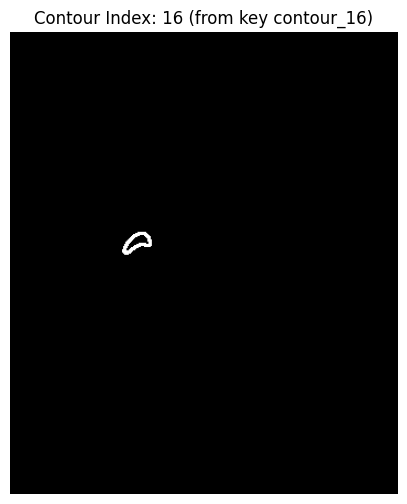

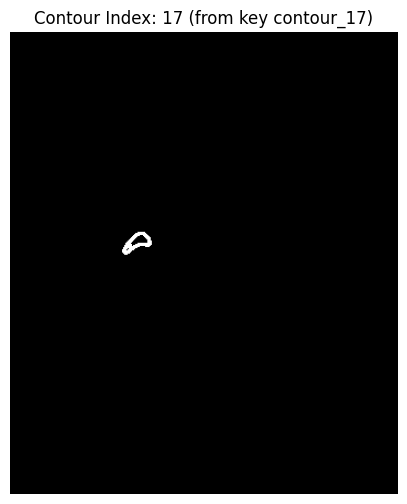

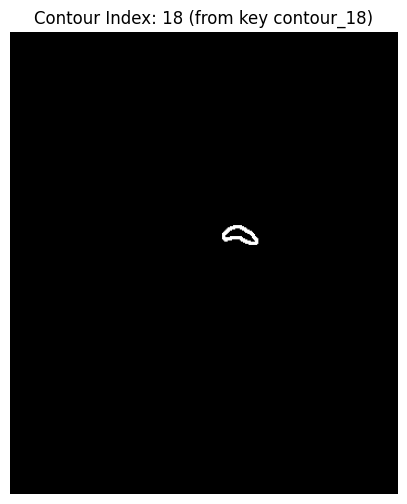

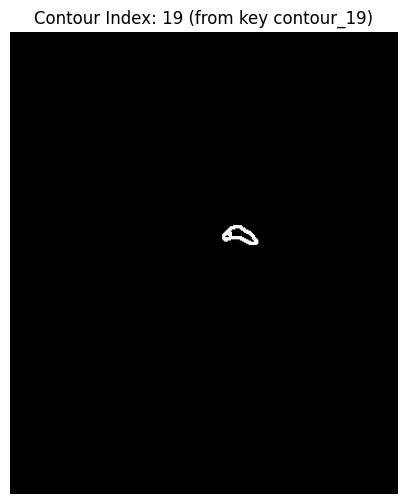

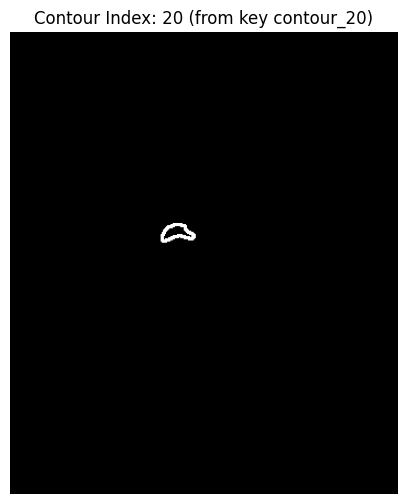

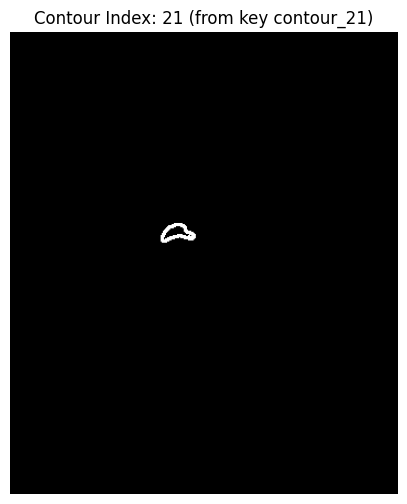

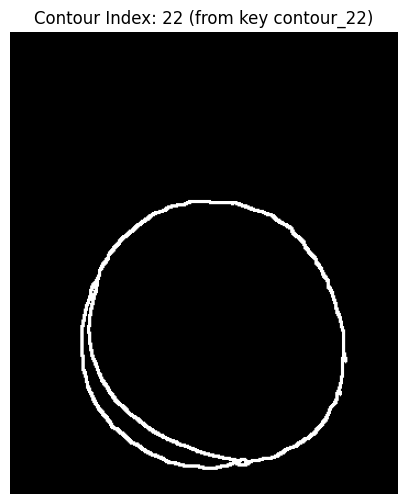

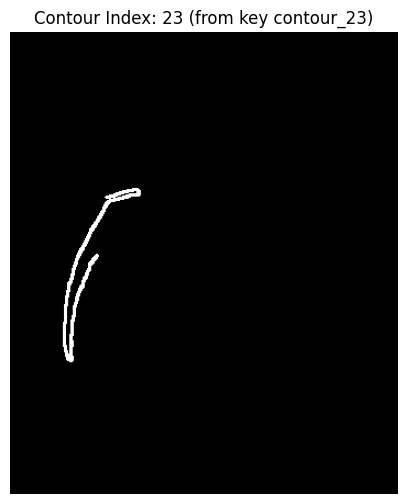

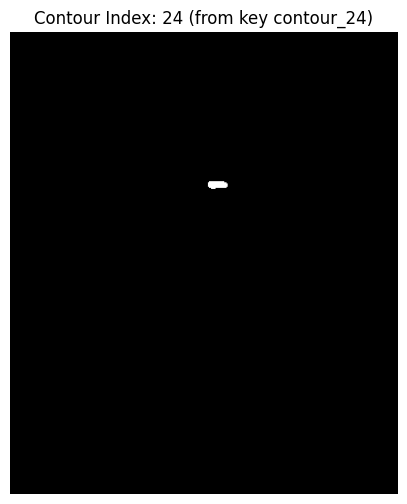

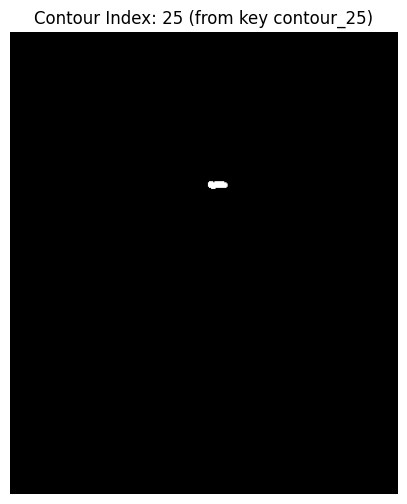

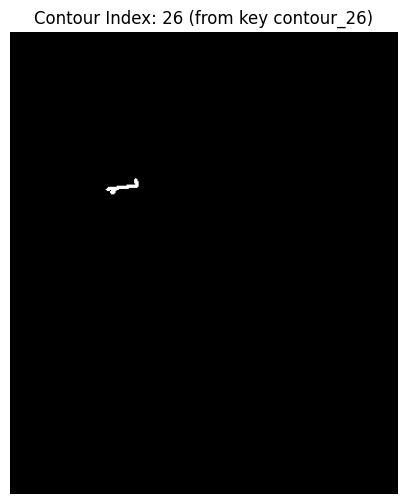

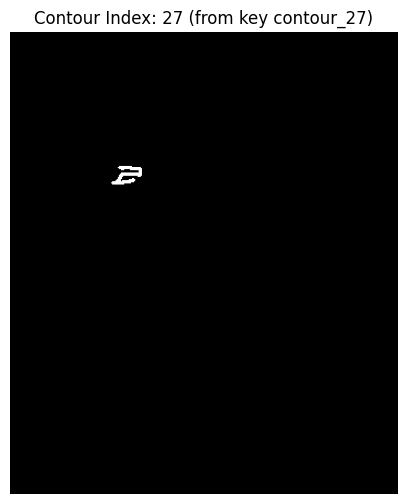

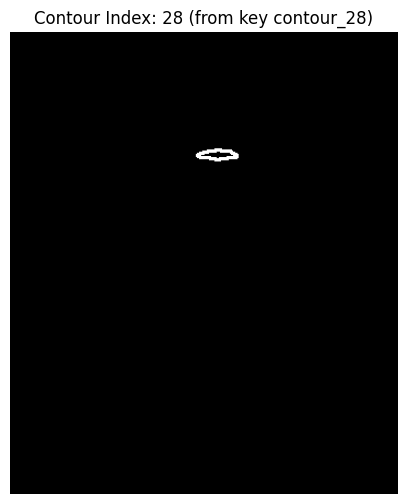

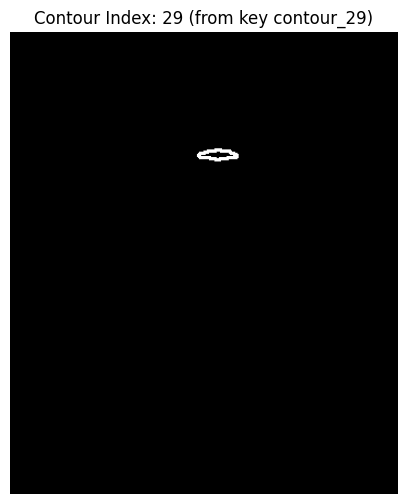

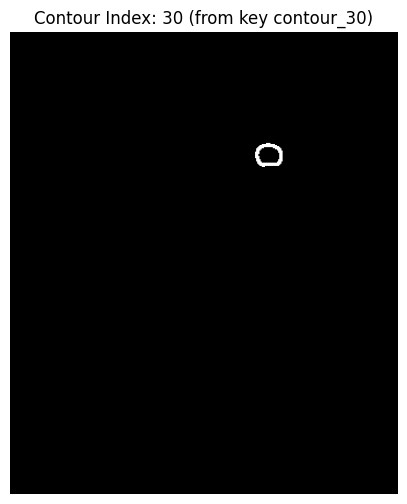

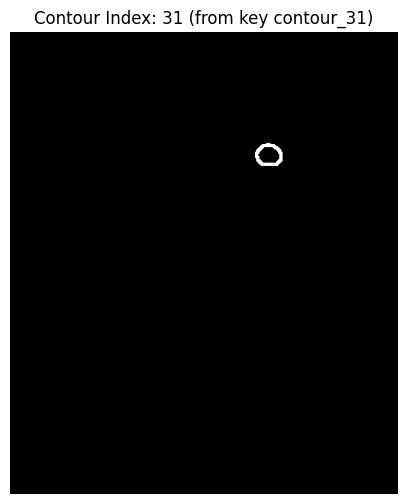

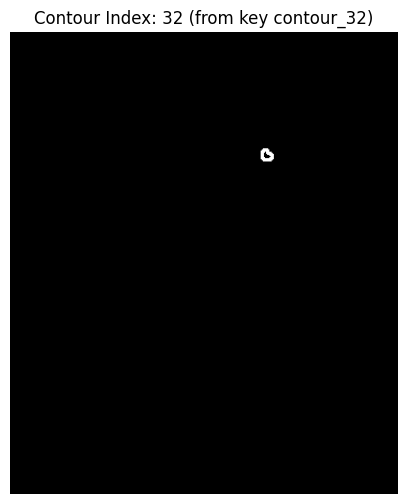

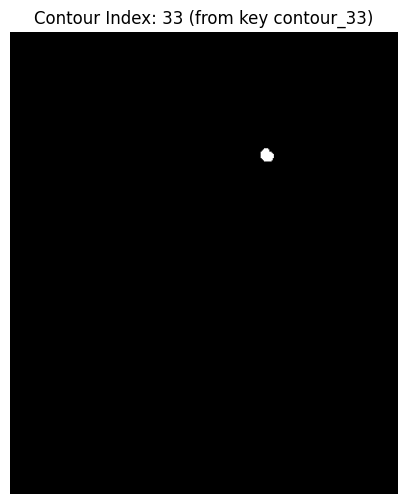

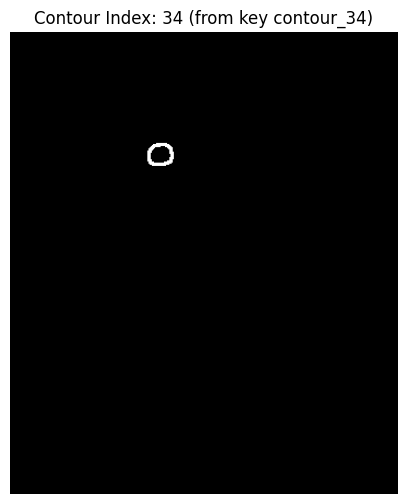

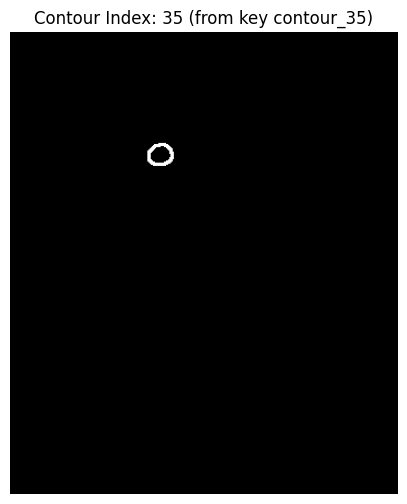

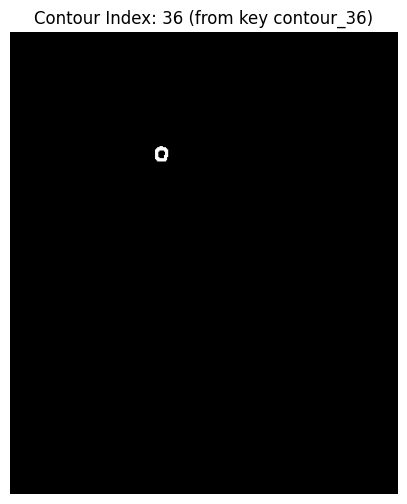

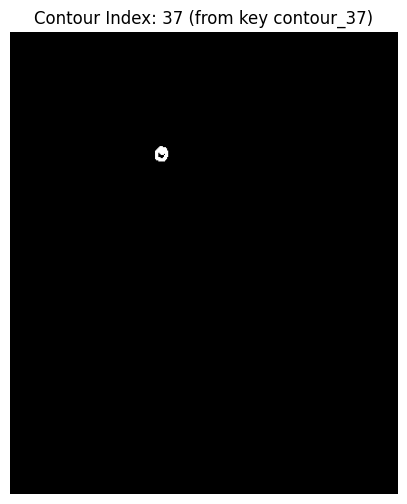

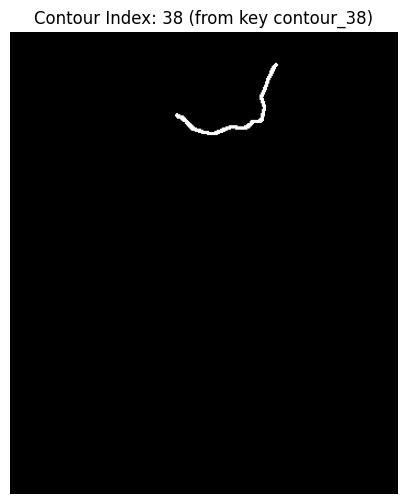

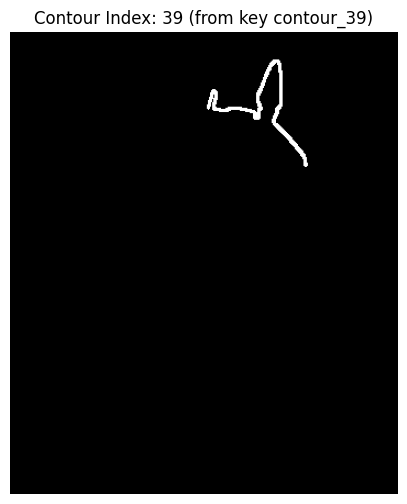

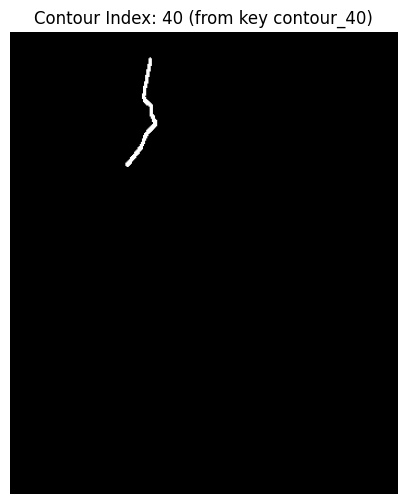

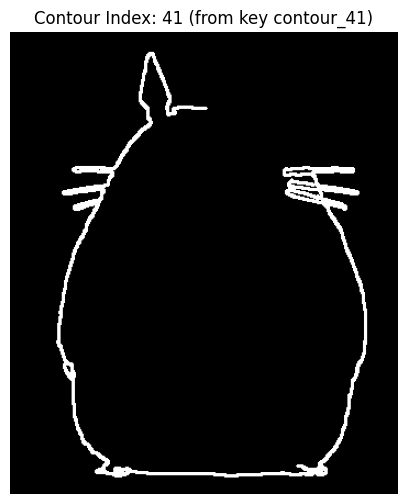

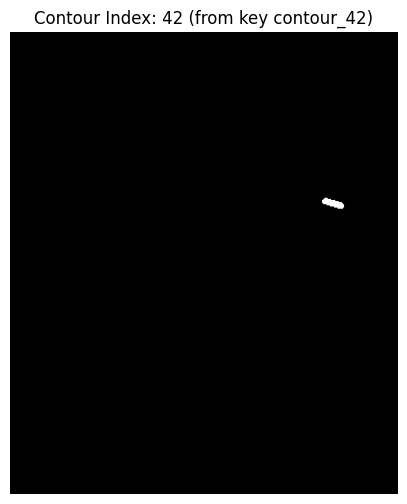

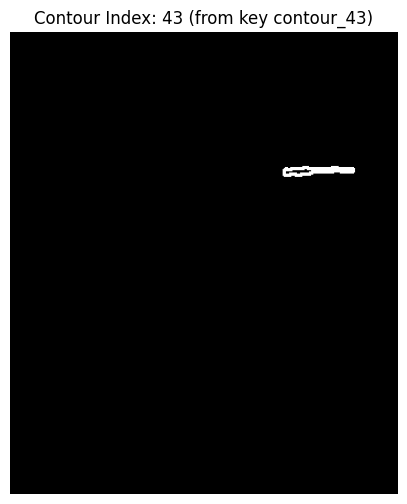


--- Visualizing All Contours Combined ---


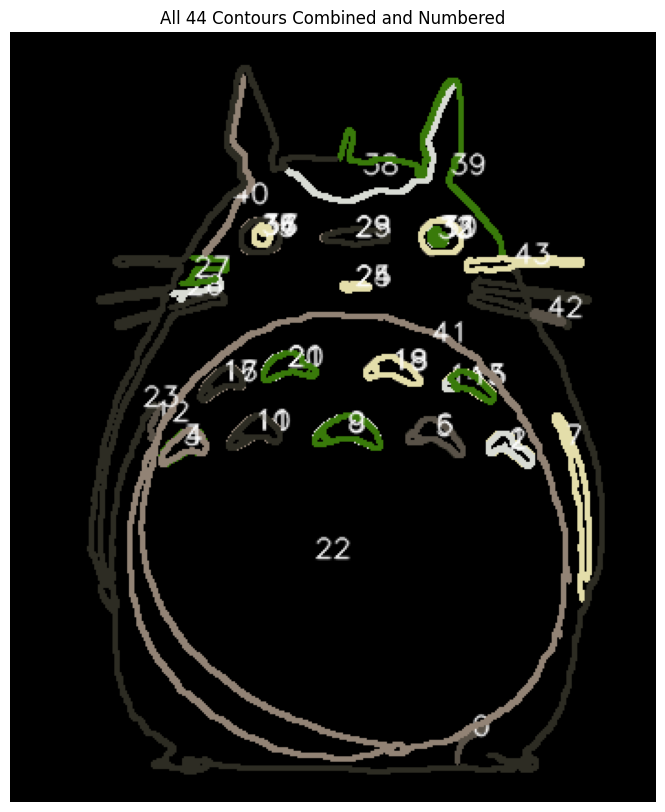

In [89]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import re # Import regular expressions for more robust key checking

# --- 1. Define Palette and File Paths ---
final_palette = [
    (89, 82, 72),
    (228, 222, 170),
    (216, 219, 212),
    (57, 122, 10),
    (146, 131, 117),
    (45, 44, 35)
]

# Convert RGB palette to BGR for OpenCV drawing
final_palette_bgr = [(r, g, b)[::-1] for (r, g, b) in final_palette]

npz_file = 'img_filtered_contours.npz'
png_file = 'img_filtered_contours.png' # Needed for image dimensions

# --- 2. Check if files exist ---
if not os.path.exists(npz_file):
    print(f"Error: NPZ file not found at '{npz_file}'. Please upload it.")
    contours = None
else:
    # --- 3. Load Contours ---
    contours = None # Initialize as None
    try:
        # Load the npz file
        data = np.load(npz_file, allow_pickle=True)
        print("Available keys in NPZ file:", data.files) # Verify keys

        all_keys = data.files
        # Filter keys that match the pattern 'contour_NUMBER'
        # Using regex for robustness: ^contour_ starts with, \d+ one or more digits, $ ends with it
        contour_keys = [k for k in all_keys if re.match(r'^contour_\d+$', k)]

        if not contour_keys:
             print(f"Error: No keys matching the pattern 'contour_NUMBER' found in {npz_file}.")
             # Optional: Check for other common keys as a fallback if needed
             # if 'contours' in data: ... etc.
        else:
            # Sort keys numerically based on the index after 'contour_'
            try:
                # Extract the number part and convert to int for sorting
                sorted_keys = sorted(contour_keys, key=lambda k: int(k.split('_')[-1]))

                # Load contours into a list in the correct order
                loaded_contours = []
                for key in sorted_keys:
                    contour_data = data[key]
                    # Basic check: Ensure it looks like contour data (numpy array)
                    if isinstance(contour_data, np.ndarray):
                         loaded_contours.append(contour_data)
                    else:
                         print(f"Warning: Data under key '{key}' is not a NumPy array, skipping.")

                if loaded_contours:
                   contours = loaded_contours # Assign the final list
                   print(f"Successfully loaded {len(contours)} contours from keys '{sorted_keys[0]}' to '{sorted_keys[-1]}' in '{npz_file}'.")
                else:
                    print(f"Warning: Found contour keys, but failed to load valid contour data.")


            except ValueError as ve:
                print(f"Error parsing contour key index for sorting: {ve}. Check key format (e.g., 'contour_1', 'contour_10'). Problematic keys might be: {contour_keys}")
            except Exception as e_load:
                print(f"Error accessing or processing data using individual keys: {e_load}")

    except Exception as e:
        print(f"Error loading NPZ file {npz_file}: {e}")


if not os.path.exists(png_file):
    print(f"Error: PNG file not found at '{png_file}'. Cannot get image dimensions. Please upload it.")
    img_shape = None
else:
     # --- 4. Load Image for Dimensions ---
    try:
        # Load the image just to get its size
        img = cv2.imread(png_file)
        if img is None:
            print(f"Error: Could not read image file '{png_file}'. Is it a valid image?")
            img_shape = None
        else:
            height, width, _ = img.shape
            img_shape = (height, width)
            print(f"Image dimensions loaded from '{png_file}': {width}x{height}")
    except Exception as e:
        print(f"Error reading image {png_file}: {e}")
        img_shape = None


# --- Visualization part (remains the same, uses the 'contours' list) ---

# Proceed only if contours and image shape were loaded successfully
if contours is not None and img_shape is not None:
    height, width = img_shape

    # --- 5. Visualize Individual Contours ---
    print("\n--- Visualizing Individual Contours ---")
    for i, contour in enumerate(contours):
        # Basic check for valid contour format before drawing
        if not isinstance(contour, np.ndarray) or contour.ndim < 2:
             print(f"Warning: Skipping invalid contour data at index {i}")
             continue

        # Create a blank black canvas
        blank_image_single = np.zeros((height, width, 3), dtype=np.uint8)

        # Draw the current contour in white
        try:
            cv2.drawContours(blank_image_single, [contour], -1, (255, 255, 255), 2) # White color (BGR)
        except cv2.error as cv_err:
             print(f"Error drawing contour index {i}: {cv_err}")
             print(f"Contour shape: {contour.shape}, dtype: {contour.dtype}")
             continue # Skip this contour

        # Display using matplotlib
        plt.figure(figsize=(6, 6))
        plt.imshow(cv2.cvtColor(blank_image_single, cv2.COLOR_BGR2RGB))
        plt.title(f'Contour Index: {i} (from key {sorted_keys[i]})') # Show original key too
        plt.axis('off')
        plt.show()

    # --- 6. Visualize All Contours Combined and Numbered ---
    print("\n--- Visualizing All Contours Combined ---")

    combined_image = np.zeros((height, width, 3), dtype=np.uint8)
    num_palette_colors = len(final_palette_bgr)

    for i, contour in enumerate(contours):
        # Basic check for valid contour format before drawing
        if not isinstance(contour, np.ndarray) or contour.ndim < 2:
             print(f"Warning: Skipping invalid contour data at index {i} for combined image.")
             continue

        color_bgr = final_palette_bgr[i % num_palette_colors]

        try:
            cv2.drawContours(combined_image, [contour], -1, color_bgr, 2)
        except cv2.error as cv_err:
             print(f"Error drawing contour index {i} on combined image: {cv_err}")
             print(f"Contour shape: {contour.shape}, dtype: {contour.dtype}")
             continue # Skip this contour


        M = cv2.moments(contour)
        cX, cY = -1, -1 # Initialize centroid coordinates
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
             # Fallback centroid: Use the average of contour points or first point
             if contour.shape[0] > 0:
                 mean_pt = contour.mean(axis=0).astype(int)
                 if mean_pt.shape[0] >= 2 : # Ensure it has x, y
                     cX, cY = mean_pt.flatten()[:2] # Take first two elements
                 elif contour[0].shape[0] >=2: # Fallback to first point
                      cX, cY = contour[0].flatten()[:2]


        # Only draw text if a valid centroid was found
        if cX != -1 and cY != -1:
             cv2.putText(combined_image, str(i), (cX, cY),
                         cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                         (255, 255, 255), 1, cv2.LINE_AA)
        else:
             print(f"Warning: Could not determine centroid for contour {i}, number not drawn.")


    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB))
    plt.title(f'All {len(contours)} Contours Combined and Numbered')
    plt.axis('off')
    plt.show()

else:
    print("\nSkipping visualization due to errors loading contours or image dimensions.")

Image shape: (421, 353, 3)
Using contours from: img_filtered_contours.npz
--- Preprocessing Settings (Initial run: All Disabled) ---
Apply Contour Simplification: False (Epsilon Factor: 0.001)
Apply Morphological Closing: False (Kernel: 3x3, Iterations: 1)
Apply Morphological Opening: False (Kernel: 3x3, Iterations: 1)
-----------------------------
Loading contours...
Loaded 44 original contours.
Creating labeled mask...
Skipping contour simplification.
Drawing contours onto mask...
Skipping morphological operations.
Running connected components analysis...
Found 20 distinct regions (excluding background label 0).
Determining region colors by sampling one pixel per region from original...
Finished assigning colors to regions using single pixel sampling.
Summary of assigned palette colors (Sampled Pixel) (Color: Number of Regions):
- (np.uint8(216), np.uint8(219), np.uint8(212)): 4
- (np.uint8(45), np.uint8(44), np.uint8(35)): 8
- (np.uint8(89), np.uint8(82), np.uint8(72)): 2
- (np.uint

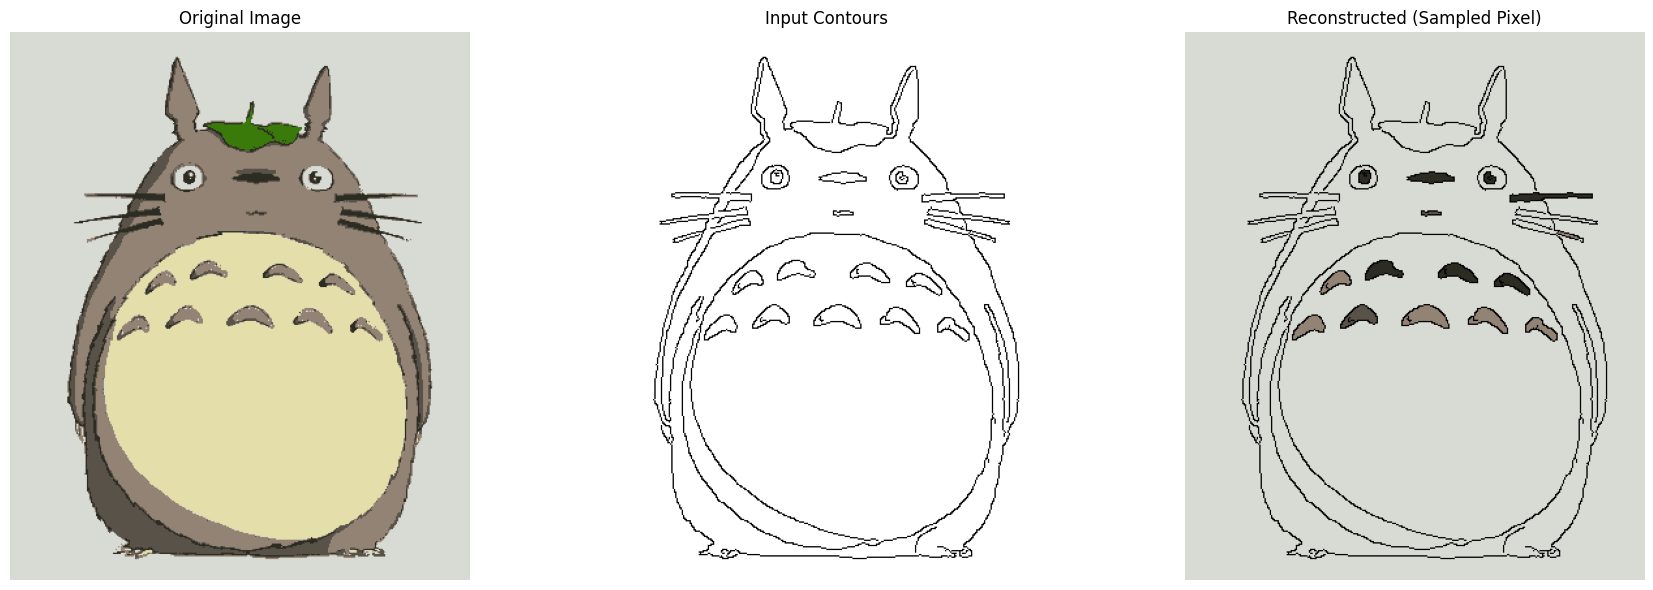

Saving reconstructed image to: reconstructed_image_sample.png
Script finished.


In [86]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import os
from skimage.color import rgb2lab # Still needed for helper functions if used elsewhere, but not in the core loop

# ------------------------------
# Configuration Flags for Preprocessing (DISABLED BY DEFAULT NOW)
# ------------------------------
APPLY_CONTOUR_SIMPLIFICATION = False # Disable first to test sampling
SIMPLIFICATION_EPSILON_FACTOR = 0.001

APPLY_MORPH_CLOSE = False          # Disable first to test sampling
MORPH_CLOSE_KERNEL_SIZE = 3
MORPH_CLOSE_ITERATIONS = 1

APPLY_MORPH_OPEN = False           # Disable first to test sampling
MORPH_OPEN_KERNEL_SIZE = 3
MORPH_OPEN_ITERATIONS = 1

# ------------------------------
# Helper Functions (LAB Distance - Not used in core loop now, but kept if needed)
# ------------------------------

contour_npz_path = "img_filtered_contours.npz"
contour_img_path = "img_filtered_contours.png" # Optional path

# --- Mandatory: Ensure display_final exists ---
if 'display_final' not in globals() or display_final is None:
    raise NameError("Variable 'display_final' is not defined or is None. Load your image first.")

# --- Input Validation ---
# ... (keep validation checks as before) ...
if not isinstance(display_final, np.ndarray) or display_final.ndim != 3 or display_final.shape[2] != 3:
     raise TypeError("display_final must be a HxWx3 NumPy array.")
if not final_palette or not all(isinstance(c, tuple) and len(c) == 3 for c in final_palette):
    raise TypeError("final_palette must be a list of 3-element RGB tuples.")
if not os.path.exists(contour_npz_path):
     raise FileNotFoundError(f"Contour NPZ file not found at: {contour_npz_path}")


print(f"Image shape: {display_final.shape}")
print(f"Using contours from: {contour_npz_path}")
print("--- Preprocessing Settings (Initial run: All Disabled) ---")
# ... (print preprocessing settings as before) ...
print(f"Apply Contour Simplification: {APPLY_CONTOUR_SIMPLIFICATION} (Epsilon Factor: {SIMPLIFICATION_EPSILON_FACTOR})")
print(f"Apply Morphological Closing: {APPLY_MORPH_CLOSE} (Kernel: {MORPH_CLOSE_KERNEL_SIZE}x{MORPH_CLOSE_KERNEL_SIZE}, Iterations: {MORPH_CLOSE_ITERATIONS})")
print(f"Apply Morphological Opening: {APPLY_MORPH_OPEN} (Kernel: {MORPH_OPEN_KERNEL_SIZE}x{MORPH_OPEN_KERNEL_SIZE}, Iterations: {MORPH_OPEN_ITERATIONS})")
print("-----------------------------")

palette_tuples = final_palette # Use the generated/fallback palette

# ------------------------------
# 1. Load Contours (same as before)
# ------------------------------
print("Loading contours...")
# ... (try-except block for loading contours remains the same) ...
try:
    contour_data = np.load(contour_npz_path, allow_pickle=True)
    original_contours = [contour_data[key] for key in contour_data.keys()]
    print(f"Loaded {len(original_contours)} original contours.")
    if not original_contours:
        raise ValueError("No contours found in the NPZ file.")
except Exception as e:
    print(f"Error loading contours from {contour_npz_path}: {e}")
    raise

# ------------------------------
# 2. Create Labeled Mask (with preprocessing flags, initially off)
# ------------------------------
print("Creating labeled mask...")
h, w = display_final.shape[:2]
# ... (Preprocessing logic using flags remains the same) ...
# --- Contour Simplification (Optional) ---
if APPLY_CONTOUR_SIMPLIFICATION:
    # ... (simplification code) ...
    print(f"Applying contour simplification (Epsilon factor: {SIMPLIFICATION_EPSILON_FACTOR})...")
    contours_to_draw = []
    simplified_count = 0
    original_point_count = 0
    simplified_point_count = 0
    for c in original_contours:
         original_point_count += len(c)
         epsilon = SIMPLIFICATION_EPSILON_FACTOR * cv2.arcLength(c, True)
         simplified_c = cv2.approxPolyDP(c, epsilon, True)
         contours_to_draw.append(simplified_c)
         simplified_point_count += len(simplified_c)
         if len(simplified_c) < len(c):
              simplified_count += 1
    print(f"Simplified {simplified_count} contours. Points reduced from {original_point_count} to {simplified_point_count}.")
else:
    print("Skipping contour simplification.")
    contours_to_draw = original_contours

# --- Draw Contours ---
contour_lines_mask = np.zeros((h, w), dtype=np.uint8)
print("Drawing contours onto mask...")
cv2.drawContours(contour_lines_mask, contours_to_draw, -1, 255, thickness=1)

# --- Invert Mask ---
regions_mask = cv2.bitwise_not(contour_lines_mask)

# --- Morphological Operations (Optional) ---
processed_regions_mask = regions_mask
if APPLY_MORPH_OPEN:
    # ... (morph open code) ...
    print(f"Applying morphological opening (Kernel: {MORPH_OPEN_KERNEL_SIZE}x{MORPH_OPEN_KERNEL_SIZE}, Iter: {MORPH_OPEN_ITERATIONS})...")
    kernel = np.ones((MORPH_OPEN_KERNEL_SIZE, MORPH_OPEN_KERNEL_SIZE), np.uint8)
    processed_regions_mask = cv2.morphologyEx(processed_regions_mask, cv2.MORPH_OPEN, kernel, iterations=MORPH_OPEN_ITERATIONS)
if APPLY_MORPH_CLOSE:
    # ... (morph close code) ...
    print(f"Applying morphological closing (Kernel: {MORPH_CLOSE_KERNEL_SIZE}x{MORPH_CLOSE_KERNEL_SIZE}, Iter: {MORPH_CLOSE_ITERATIONS})...")
    kernel = np.ones((MORPH_CLOSE_KERNEL_SIZE, MORPH_CLOSE_KERNEL_SIZE), np.uint8)
    processed_regions_mask = cv2.morphologyEx(processed_regions_mask, cv2.MORPH_CLOSE, kernel, iterations=MORPH_CLOSE_ITERATIONS)
if not APPLY_MORPH_OPEN and not APPLY_MORPH_CLOSE:
    print("Skipping morphological operations.")


# --- Connected Components ---
print("Running connected components analysis...")
num_labels, labeled_mask, stats, centroids = cv2.connectedComponentsWithStats(processed_regions_mask, connectivity=4)
print(f"Found {num_labels - 1} distinct regions (excluding background label 0).")

# ------------------------------
# 3. Determine Region Color by Sampling ONE Pixel from Original Image
# ------------------------------
print("Determining region colors by sampling one pixel per region from original...")
label_colors = {} # Dictionary to store {label_id: exact_rgb_color}
assigned_colors_summary = Counter()

for label in range(1, num_labels): # Iterate through each region label (skip 0)
    # Find coordinates of all pixels belonging to this label
    region_coords = np.argwhere(labeled_mask == label)

    if region_coords.size == 0:
        # Region is empty (maybe preprocessing removed it)
        assigned_color_tuple = (0, 0, 0) # Default to black
        # print(f"Debug: Label {label}: Empty region.")
    else:
        # 1. Pick the first coordinate found for this label as the sample point
        #    np.argwhere returns pairs of [row, col]
        sample_coord = region_coords[0] # Gives [row, col]
        sample_y, sample_x = sample_coord[0], sample_coord[1]

        # 2. Get the exact color from the original display_final image at this coordinate
        #    Access directly using the coordinates. Convert NumPy array pixel to tuple.
        exact_color_np = display_final[sample_y, sample_x]
        assigned_color_tuple = tuple(exact_color_np)

        # 3. Check if the sampled color is actually in the defined palette (optional sanity check)
        # if assigned_color_tuple not in palette_tuples:
        #    print(f"WARNING: Sampled color {assigned_color_tuple} for label {label} not in defined palette! Check 'display_final' guarantee.")
        #    # Decide fallback: maybe use nearest palette color anyway? Or keep the sampled color?
        #    # assigned_color_tuple = find_nearest_color(assigned_color_tuple, palette_tuples) # Optional fallback


        # --- DEBUG Print (Optional) ---
        # area = stats[label, cv2.CC_STAT_AREA]
        # print(f"Debug: Label {label}: Area={area}, Sampled Coord=({sample_y},{sample_x}), Assigned Color={assigned_color_tuple}")
        # ---

    # Store the determined exact color for this label
    label_colors[label] = assigned_color_tuple
    assigned_colors_summary[assigned_color_tuple] += 1


print("Finished assigning colors to regions using single pixel sampling.")
print("Summary of assigned palette colors (Sampled Pixel) (Color: Number of Regions):")
# ... (Summary printing logic remains the same) ...
for color, num_regions in assigned_colors_summary.items():
    print(f"- {color}: {num_regions}")
if not assigned_colors_summary:
     print("- No regions were assigned colors.")
elif len(assigned_colors_summary) < len(palette_tuples):
     print(f"Info: {len(assigned_colors_summary)} out of {len(palette_tuples)} palette colors were assigned.")
if len(assigned_colors_summary) == 1 and num_labels > 2:
     print("WARNING: Only one palette color was assigned to all regions. Check region definition (contours/preprocessing).")


# ------------------------------
# 4. Reconstruct the Image (same as before)
# ------------------------------
print("Reconstructing the image...")
# ... (Reconstruction logic remains the same: fill using label_colors) ...
reconstructed_image = np.zeros_like(display_final)
for label, color in label_colors.items():
    reconstructed_image[labeled_mask == label] = color
reconstructed_image[labeled_mask == 0] = (0, 0, 0) # Black background/lines
print("Reconstruction complete.")

# ------------------------------
# 5. Display the Results (same as before)
# ------------------------------
print("Displaying results...")
# ... (matplotlib plotting logic remains the same) ...
# ... (Load contour_display_image) ...
contour_display_image = None
if os.path.exists(contour_img_path):
    contour_display_image = cv2.imread(contour_img_path, cv2.IMREAD_GRAYSCALE)
    if contour_display_image is None: print(f"Warning: Could not load contour image from {contour_img_path}")

num_plots = 3 if contour_display_image is not None else 2
plt.figure(figsize=(6 * num_plots, 6))

plt.subplot(1, num_plots, 1)
plt.imshow(display_final)
plt.title("Original Image")
plt.axis('off')

if contour_display_image is not None:
    plt.subplot(1, num_plots, 2)
    plt.imshow(contour_display_image, cmap='gray')
    plt.title("Input Contours")
    plt.axis('off')

plt.subplot(1, num_plots, num_plots)
plt.imshow(reconstructed_image)
plt.title("Reconstructed (Sampled Pixel)") # Updated title
plt.axis('off')

plt.tight_layout()
plt.show()


# ------------------------------
# 6. Optional: Save the Result
# ------------------------------
# Construct filename based on settings
settings_tag = "_sample" # Indicate sampling method
if APPLY_CONTOUR_SIMPLIFICATION: settings_tag += "_simp"
if APPLY_MORPH_OPEN: settings_tag += "_open"
if APPLY_MORPH_CLOSE: settings_tag += "_close"
save_path = f"reconstructed_image{settings_tag}.png"

print(f"Saving reconstructed image to: {save_path}")
cv2.imwrite(save_path, cv2.cvtColor(reconstructed_image, cv2.COLOR_RGB2BGR))

print("Script finished.")

# Image Layering

In [37]:
from collections import defaultdict, deque
from ipywidgets import interact, IntSlider, FloatSlider, Button, VBox
from IPython.display import display
from ipywidgets import Button
import matplotlib.pyplot as plt
from scipy.ndimage import label, find_objects, binary_erosion
import heapq  # We'll use heapq as a priority queue for topological sort

In [38]:
image_for_cc = display_final.copy()

In [39]:
# ---------------- Helper Functions ----------------

def compute_circumference(mask):
    """
    Compute the perimeter of a connected component using binary erosion.
    """
    edge_mask = binary_dilation(mask, np.ones((3,3))) ^ mask
    return np.sum(edge_mask)

def get_component_image(element, has_alpha=False):
    """
    Given an element (with keys "bbox", "mask", "color"), create an image of its bounding box
    with the component painted in its color.
    """
    y_min, y_max, x_min, x_max = element["bbox"]
    height = y_max - y_min
    width = x_max - x_min
    if has_alpha:
        comp_img = np.dstack((
            255*np.ones((height, width), dtype=np.uint8),
            255*np.ones((height, width), dtype=np.uint8),
            255*np.ones((height, width), dtype=np.uint8),
            np.zeros((height, width), dtype=np.uint8)
        ))
        comp_img[element["mask"]] = list(element["color"]) + [255]
    else:
        comp_img = 255 * np.ones((height, width, 3), dtype=np.uint8)
        comp_img[element["mask"]] = element["color"]

    return comp_img

def display_components_grid(layers_dict, has_alpha=False):
    """
    Display a grid where each row corresponds to a layer and each cell shows the component image.
    """
    layer_numbers = sorted(layers_dict.keys())
    if not layer_numbers:
        print("No layers to display.")
        return

    max_cols = max(len(layers_dict[layer]) for layer in layer_numbers)

    fig, axes = plt.subplots(nrows=len(layer_numbers), ncols=max_cols, figsize=(max_cols*3, len(layer_numbers)*3))
    if len(layer_numbers) == 1:
        axes = np.expand_dims(axes, axis=0)
    if max_cols == 1:
        axes = np.expand_dims(axes, axis=1)

    for row_idx, layer in enumerate(layer_numbers):
        components = layers_dict[layer]
        for col_idx in range(max_cols):
            ax = axes[row_idx, col_idx]
            if col_idx < len(components):
                comp_img = get_component_image(components[col_idx], has_alpha=has_alpha)
                ax.imshow(comp_img)
                ax.set_title(f"ID {components[col_idx]['id']}")
            else:
                ax.axis('off')
            if col_idx == 0:
                ax.set_ylabel(f"Layer {layer}", rotation=0, size='large', labelpad=40)
            ax.axis('off')
    plt.tight_layout()
    plt.show()


In [40]:
# ---------------- More Helper Functions ----------------


def get_global_mask(elem, full_shape):
    """Create a full-size binary mask for an element using its bbox and local mask."""
    global_mask = np.zeros(full_shape, dtype=bool)
    y_min, y_max, x_min, x_max = elem["bbox"]
    global_mask[y_min:y_max, x_min:x_max] = elem["mask"]
    return global_mask

def is_element_inside(inner, outer, full_shape, threshold=0.95):
    """
    Determine if 'inner' is mostly inside 'outer' using pixel-level masks.
    Returns True if at least 'threshold' fraction of inner's pixels are contained in outer.
    """
    y1, y2, x1, x2 = inner["bbox"]
    oy1, oy2, ox1, ox2 = outer["bbox"]
    if oy1 > y1 or oy2 < y2 or ox1 > x1 or ox2 < x2:
        return False
    inner_global = get_global_mask(inner, full_shape)
    outer_global = get_global_mask(outer, full_shape)
    inner_region = inner_global[y1:y2, x1:x2]
    outer_region = outer_global[y1:y2, x1:x2]
    if inner_region.sum() == 0:
        return False
    overlap = np.logical_and(inner_region, outer_region).sum()
    return (overlap / inner_region.sum()) >= threshold

def is_outline(elem, fill_ratio_thresh=0.1, max_outline_area=20):
    """
    Determine if an element appears to be merely an outline.
    Uses binary erosion on the element’s mask; if erosion removes all pixels
    (i.e. the mask is only 1-pixel thick) and the element's area is below
    max_outline_area, then if its fill ratio is below fill_ratio_thresh,
    the element is considered an outline.
    """
    eroded = binary_erosion(elem["mask"], structure=np.ones((3,3)))
    if eroded.sum() == 0 and elem["area"] <= max_outline_area:
        y_min, y_max, x_min, x_max = elem["bbox"]
        bbox_area = (y_max - y_min) * (x_max - x_min)
        if bbox_area > 0:
            fill_ratio = elem["area"] / bbox_area
            if fill_ratio < fill_ratio_thresh:
                return True
    return False

def are_adjacent(elem1, elem2, dilation=1):
    """
    Determine if two elements are adjacent based on their bounding boxes.
    Their bboxes are dilated by 'dilation' pixels; if the dilated boxes overlap,
    the elements are considered adjacent.
    """
    y1, y2, x1, x2 = elem1["bbox"]
    y1o, y2o, x1o, x2o = elem2["bbox"]
    y1_d, y2_d = y1 - dilation, y2 + dilation
    x1_d, x2_d = x1 - dilation, x2 + dilation
    y1o_d, y2o_d = y1o - dilation, y2o + dilation
    x1o_d, x2o_d = x1o - dilation, x2o + dilation
    if x2_d < x1o_d or x2o_d < x1_d:
        return False
    if y2_d < y1o_d or y2o_d < y1_d:
        return False
    return True

# --------------- Union-Find Helpers ----------------
def uf_find(parent, i):
    if parent[i] != i:
        parent[i] = uf_find(parent, parent[i])
    return parent[i]

def uf_union(parent, rank, i, j):
    i_id = uf_find(parent, i)
    j_id = uf_find(parent, j)
    if i_id == j_id:
        return
    if rank[i_id] < rank[j_id]:
        parent[i_id] = j_id
    elif rank[i_id] > rank[j_id]:
        parent[j_id] = i_id
    else:
        parent[j_id] = i_id
        rank[i_id] += 1


In [41]:
# ---------------- Global Variables for Storage ----------------

# This will hold the *most recent* layer-images computed by `run_layering`.
# We update it every time the user changes a slider.
layer_images_temp = []

# This will hold the final “approved” layer-images after the user clicks the button.
layer_images = []


# ---------------- Main Function with Dynamic Parameters ----------------

def run_layering(alpha=100, merge_threshold=3, fill_ratio_thresh=0.1, max_outline_area=20, adj_dilation=1):
    """
    Run the segmentation and layering pipeline with dynamic parameters.

    Parameters:
      alpha: Tuning constant for the priority formula.
      merge_threshold: Maximum difference between layer numbers (for same-color elements) to merge.
      fill_ratio_thresh: Fill ratio threshold for outline detection.
      max_outline_area: Maximum area for an element to be considered for outline removal.
      adj_dilation: Number of pixels to dilate bounding boxes when determining adjacency.
    """
    global layer_images_temp

    # Assumed globals:
    # - image_for_cc: RGB NumPy array (cartoonized image)
    # - final_palette: list of RGB tuples
    # - fg_mask: Boolean foreground mask
    # - compute_circumference(mask): function to compute perimeter
    # The final images are displayed in a grid.

    all_elements = []
    element_id = 0
    min_component_area = 10   # Skip very tiny segments

    # Step 1: Extract Connected Components for Each Color.
    for color in final_palette:
        mask = np.all(image_for_cc == color, axis=-1)
        mask &= fg_mask
        labeled_array, num_features = label(mask, structure=np.ones((3,3), dtype=int))
        slices = find_objects(labeled_array)

        for comp_index, sl in enumerate(slices, start=1):
            comp_mask = (labeled_array[sl] == comp_index)
            comp_size = np.sum(comp_mask)
            if comp_size < min_component_area:
                continue
            circumference = compute_circumference(comp_mask)
            bbox = (sl[0].start, sl[0].stop, sl[1].start, sl[1].stop)
            complexity = circumference / comp_size if comp_size > 0 else float('inf')

            elem = {
                "id": element_id,
                "color": color,
                "area": comp_size,
                "circumference": circumference,
                "bbox": bbox,
                "mask": comp_mask,  # Local coordinates within bbox.
                "enveloped_by": None,
                "layer": None,
                "complexity": complexity
            }
            all_elements.append(elem)
            element_id += 1

    all_elements = [e for e in all_elements if e["area"] >= min_component_area]

    # Step 2: Remove Outline-like Elements.
    all_elements = [e for e in all_elements if not is_outline(e, fill_ratio_thresh=fill_ratio_thresh, max_outline_area=max_outline_area)]

    # Step 3: Determine Engulfing Relationships.
    full_shape = image_for_cc.shape[:2]
    for elem in all_elements:
        candidate_parents = []
        for other in all_elements:
            if other["id"] == elem["id"]:
                continue
            if is_element_inside(elem, other, full_shape, threshold=0.95):
                candidate_parents.append(other)
        if candidate_parents:
            parent_elem = min(candidate_parents, key=lambda f: f["area"])
            elem["enveloped_by"] = parent_elem["id"]

    # Step 4: Compute Combined Priority.
    for e in all_elements:
        e["priority"] = e["complexity"] + alpha * (1.0 / e["area"])

    # Step 5: Preliminary Layer Assignment.
    sorted_elements = sorted(all_elements, key=lambda e: e["priority"], reverse=True)
    for i, e in enumerate(sorted_elements):
        e["layer"] = i + 1
    for e in sorted_elements:
        if e["enveloped_by"] is not None:
            parent_elem = next((p for p in sorted_elements if p["id"] == e["enveloped_by"]), None)
            if parent_elem and e["layer"] <= parent_elem["layer"]:
                e["layer"] = parent_elem["layer"] + 1

    # Step 6: Merge Adjacent Same-Color Elements (using union-find).
    n = len(sorted_elements)
    parent = list(range(n))
    rank = [0] * n
    color_to_indices = defaultdict(list)
    for idx, e in enumerate(sorted_elements):
        color_to_indices[e["color"]].append(idx)
    for color, indices in color_to_indices.items():
        for i in range(len(indices)):
            for j in range(i+1, len(indices)):
                idx_i = indices[i]
                idx_j = indices[j]
                if are_adjacent(sorted_elements[idx_i], sorted_elements[idx_j], dilation=adj_dilation):
                    uf_union(parent, rank, idx_i, idx_j)
    group_min_layer = {}
    for i in range(n):
        root = uf_find(parent, i)
        group_min_layer[root] = min(group_min_layer.get(root, float('inf')), sorted_elements[i]["layer"])
    for i in range(n):
        root = uf_find(parent, i)
        sorted_elements[i]["layer"] = group_min_layer[root]

    # Step 7: Merge Nearby Layers for the Same Color.
    merge_thresh = merge_threshold
    color_groups = defaultdict(list)
    for e in sorted_elements:
        color_groups[e["color"]].append(e)
    for color, group in color_groups.items():
        group.sort(key=lambda x: x["layer"])
        current_cluster = [group[0]]
        for e in group[1:]:
            if e["layer"] - current_cluster[-1]["layer"] <= merge_thresh:
                current_cluster.append(e)
            else:
                common_layer = min(x["layer"] for x in current_cluster)
                for x in current_cluster:
                    x["layer"] = common_layer
                current_cluster = [e]
        if current_cluster:
            common_layer = min(x["layer"] for x in current_cluster)
            for x in current_cluster:
                x["layer"] = common_layer

    # Step 8: Build the layer_images list and display them.
    layers_dict = defaultdict(list)
    for e in sorted_elements:
        layers_dict[e["layer"]].append(e)

    H, W = image_for_cc.shape[:2]
    new_layer_images = []
    for layer in sorted(layers_dict.keys()):
        layer_img = 255 * np.ones((H, W, 3), dtype=np.uint8)  # White background
        for elem in layers_dict[layer]:
            y_min, y_max, x_min, x_max = elem["bbox"]
            layer_img[y_min:y_max, x_min:x_max][elem["mask"]] = np.array(elem["color"], dtype=np.uint8)
        new_layer_images.append((layer, layer_img))

    # Update the global "temp" images (latest result).
    layer_images_temp = new_layer_images

    # --- Display the images in a grid ---
    n_layers = len(new_layer_images)
    ncols = min(n_layers, 5)
    nrows = math.ceil(n_layers / max(ncols, 1))
    fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))
    if nrows == 1 and ncols == 1:
        axes = np.array([[axes]])
    elif nrows == 1:
        axes = np.expand_dims(axes, axis=0)
    elif ncols == 1:
        axes = np.expand_dims(axes, axis=1)

    for idx, (layer, img) in enumerate(new_layer_images):
        row = idx // ncols
        col = idx % ncols
        axes[row, col].imshow(img)
        axes[row, col].set_title(f"Layer {layer}")
        axes[row, col].axis('off')
    for idx in range(n_layers, nrows * ncols):
        row = idx // ncols
        col = idx % ncols
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()


# ---------------- Interactive Sliders ----------------
_ = interact(run_layering,
             alpha=IntSlider(value=100, min=10, max=300, step=10, description="Alpha"),
             merge_threshold=IntSlider(value=3, min=1, max=100, step=1, description="Merge Thresh"),
             fill_ratio_thresh=FloatSlider(value=0.1, min=0.01, max=1.0, step=0.01, description="Fill Ratio Thresh"),
             max_outline_area=IntSlider(value=20, min=1, max=100, step=1, description="Max Outline Area"),
             adj_dilation=IntSlider(value=1, min=0, max=20, step=1, description="Adjacency Dilation"))

# ---------------- Button to Save the Final Layer Images Globally ----------------
save_button = Button(description="Save Layer Images to Global")

def on_save_button_clicked(b):
    """
    When clicked, copies the current layer_images_temp
    into the global 'layer_images' variable.
    """
    global layer_images_temp, layer_images
    if len(layer_images_temp) == 0:
        print("No layering results found. Adjust sliders and let run_layering generate images first.")
    else:
        layer_images = layer_images_temp
        print("Successfully saved the current layering to the global variable 'layer_images'.")

save_button.on_click(on_save_button_clicked)

display(VBox([save_button]))


interactive(children=(IntSlider(value=100, description='Alpha', max=300, min=10, step=10), IntSlider(value=3, …

In [42]:
amalgamation_images = []

if len(layer_images) == 0:
    print("No layers found in 'layer_images'. Please run your pipeline first.")
else:
    # We will create a new image for each layer i that includes
    # all shapes from layer i+1..end, but colored with layer i's color.

    for i in range(len(layer_images)):
        layer_num_i, base_img_i = layer_images[i]

        # Make a copy so we can modify it
        amalgam = np.copy(base_img_i)

        # Detect the base color for layer i by looking for the first non-white pixel
        mask_i = np.any(base_img_i != [255, 255, 255], axis=-1)
        coords_i = np.argwhere(mask_i)

        if len(coords_i) == 0:
            # This layer is completely white; there's no “color.” We'll do nothing special,
            # so it stays all white unless subsequent layers' shapes are added (colored white).
            # We can just store it as-is and move on, but it won't change.
            color_i = np.array([255, 255, 255], dtype=np.uint8)
        else:
            # Use the first non-white pixel as the base color
            y_i, x_i = coords_i[0]
            color_i = base_img_i[y_i, x_i]

        # Now incorporate shapes from layers above i
        for j in range(i+1, len(layer_images)):
            # The shape from layer j
            _, layer_img_j = layer_images[j]
            # Identify the painted (non-white) pixels in layer j
            mask_j = np.any(layer_img_j != [255, 255, 255], axis=-1)
            # Overwrite those pixels in 'amalgam' with layer i's color
            amalgam[mask_j] = color_i

        # Store this new image
        amalgamation_images.append((layer_num_i, amalgam))

    # --------------- Display the results in a grid ---------------
    n_layers = len(amalgamation_images)
    ncols = min(n_layers, 5)
    nrows = math.ceil(n_layers / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))

    # Ensure axes is always a 2D array
    if nrows == 1 and ncols == 1:
        axes = np.array([[axes]])
    elif nrows == 1:
        axes = np.expand_dims(axes, axis=0)
    elif ncols == 1:
        axes = np.expand_dims(axes, axis=1)

    for idx, (layer_num, img) in enumerate(amalgamation_images):
        row = idx // ncols
        col = idx % ncols
        axes[row, col].imshow(img)
        axes[row, col].set_title(f"Layer {layer_num} + Above (Color {layer_num})")
        axes[row, col].axis('off')

    # Turn off any leftover subplots if our grid is larger
    for idx in range(n_layers, nrows*ncols):
        row = idx // ncols
        col = idx % ncols
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()


No layers found in 'layer_images'. Please run your pipeline first.
